In [83]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from datetime import datetime

# 1) Loading the dataset
Loading the dataset and removing columns that are not needed.

In [84]:
# load the ED visits dataset with all the features
df_event_log_visits = pd.read_csv('df_visits_dur_timeofday-randomorder.csv')

In [85]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497856 entries, 0 to 497855
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      497856 non-null  object 
 1   SEX                      497856 non-null  object 
 2   DOB                      497852 non-null  object 
 3   DOD                      27730 non-null   object 
 4   ED_POSTAL_CODE           496704 non-null  object 
 5   FACILITY_ID              497856 non-null  object 
 6   FACILITY_NAME            497856 non-null  object 
 7   VISIT_ID                 497856 non-null  object 
 8   VISIT_AGE                497852 non-null  float64
 9   CTAS                     489358 non-null  float64
 10  REASON_FOR_VISIT         493072 non-null  object 
 11  PRESENTING_COMPLAINT     496613 non-null  object 
 12  DEPART_DISPOSITION_ID    496031 non-null  object 
 13  DEPART_DISPOSITION_DESC  496031 non-null  object 
 14  Acti

In [86]:
# dropping columns that were added earlier for analytics
df_event_log_visits.drop(['Earliest_Time'], axis=1, inplace=True)

In [87]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497856 entries, 0 to 497855
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      497856 non-null  object 
 1   SEX                      497856 non-null  object 
 2   DOB                      497852 non-null  object 
 3   DOD                      27730 non-null   object 
 4   ED_POSTAL_CODE           496704 non-null  object 
 5   FACILITY_ID              497856 non-null  object 
 6   FACILITY_NAME            497856 non-null  object 
 7   VISIT_ID                 497856 non-null  object 
 8   VISIT_AGE                497852 non-null  float64
 9   CTAS                     489358 non-null  float64
 10  REASON_FOR_VISIT         493072 non-null  object 
 11  PRESENTING_COMPLAINT     496613 non-null  object 
 12  DEPART_DISPOSITION_ID    496031 non-null  object 
 13  DEPART_DISPOSITION_DESC  496031 non-null  object 
 14  Acti

In [88]:
# Rename the Start_Time column to Activity_End_Time - there is only one time stamp in the dataset which is assumed to be
# when the activity finished
df_event_log_visits.rename(columns={'Start_Time': 'Activity_End_Time'}, inplace=True)

# Drop the End_Time column
df_event_log_visits.drop(columns=['End_Time'], inplace=True)


In [89]:

# Sort the DataFrame by VISIT_ID and Activity_End_Time
df_event_log_visits.sort_values(by=['VISIT_ID', 'Activity_End_Time'], inplace=True)

# Infer Start_Time for each activity using the Activity_End_Time of the previous activity
df_event_log_visits['Start_Time'] = df_event_log_visits['Activity_End_Time'].shift(1)

# Ensure that the Start_Time is not carried over from the last activity of the previous VISIT_ID to the first activity of the next VISIT_ID
df_event_log_visits.loc[df_event_log_visits['VISIT_ID'] != df_event_log_visits['VISIT_ID'].shift(1), 'Start_Time'] = pd.NaT

# For the first activity in each sequence, set Start_Time equal to Activity_End_Time, indicating zero duration
df_event_log_visits.loc[df_event_log_visits['Start_Time'].isna(), 'Start_Time'] = df_event_log_visits['Activity_End_Time']


In [90]:
# these are the remaining columns in the dataset as of now
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497856 entries, 0 to 497855
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      497856 non-null  object 
 1   SEX                      497856 non-null  object 
 2   DOB                      497852 non-null  object 
 3   DOD                      27730 non-null   object 
 4   ED_POSTAL_CODE           496704 non-null  object 
 5   FACILITY_ID              497856 non-null  object 
 6   FACILITY_NAME            497856 non-null  object 
 7   VISIT_ID                 497856 non-null  object 
 8   VISIT_AGE                497852 non-null  float64
 9   CTAS                     489358 non-null  float64
 10  REASON_FOR_VISIT         493072 non-null  object 
 11  PRESENTING_COMPLAINT     496613 non-null  object 
 12  DEPART_DISPOSITION_ID    496031 non-null  object 
 13  DEPART_DISPOSITION_DESC  496031 non-null  object 
 14  Acti

In [91]:

# Convert the 'Duration' column to timedelta
df_event_log_visits['Duration'] = pd.to_timedelta(df_event_log_visits['Duration'])

# Rename the column and convert the values to hours
df_event_log_visits['Duration_hours'] = df_event_log_visits['Duration'].dt.total_seconds() / 3600

# Drop the old 'Duration' column
df_event_log_visits = df_event_log_visits.drop(columns=['Duration'])


In [92]:

# filtering out the columns I move to the end
columns = list(df_event_log_visits.columns)
columns.remove('Activity_End_Time')
columns.remove('Duration_hours')


# Appending them
columns = columns + ['Activity_End_Time', 'Duration_hours']

# Reordring based on the new column order
df_event_log_visits = df_event_log_visits[columns]

df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,REASON_FOR_VISIT,PRESENTING_COMPLAINT,DEPART_DISPOSITION_ID,DEPART_DISPOSITION_DESC,Activity,TIME_OF_THE_DAY,Start_Time,Activity_End_Time,Duration_hours
0,STDY147061,F,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,SOB/COUGH PRODUCTIVE,SHORTNESS OF BREATH,D,DISCHARGED W/O SUPPORT SERV,Triage,Early Morning to Morning,2022-04-01 00:22:00+00:00,2022-04-01 00:22:00+00:00,0.550000
1,STDY147061,F,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,SOB/COUGH PRODUCTIVE,SHORTNESS OF BREATH,D,DISCHARGED W/O SUPPORT SERV,Providing service,Early Morning to Morning,2022-04-01 00:22:00+00:00,2022-04-01 00:24:00+00:00,0.550000
2,STDY147061,F,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,SOB/COUGH PRODUCTIVE,SHORTNESS OF BREATH,D,DISCHARGED W/O SUPPORT SERV,Assessment,Early Morning to Morning,2022-04-01 00:24:00+00:00,2022-04-01 00:30:00+00:00,0.550000
3,STDY147061,F,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,SOB/COUGH PRODUCTIVE,SHORTNESS OF BREATH,D,DISCHARGED W/O SUPPORT SERV,Patient departed,Early Morning to Morning,2022-04-01 00:30:00+00:00,2022-04-01 00:55:00+00:00,0.550000
4,STDY321073,M,1999-02-08,NaN,A1B1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,L ANKLE INJURY,LOWER EXTREMITY INJURY,D,DISCHARGED W/O SUPPORT SERV,Triage,Early Morning to Morning,2022-04-01 00:40:00+00:00,2022-04-01 00:40:00+00:00,5.333333


In [93]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497856 entries, 0 to 497855
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      497856 non-null  object 
 1   SEX                      497856 non-null  object 
 2   DOB                      497852 non-null  object 
 3   DOD                      27730 non-null   object 
 4   ED_POSTAL_CODE           496704 non-null  object 
 5   FACILITY_ID              497856 non-null  object 
 6   FACILITY_NAME            497856 non-null  object 
 7   VISIT_ID                 497856 non-null  object 
 8   VISIT_AGE                497852 non-null  float64
 9   CTAS                     489358 non-null  float64
 10  REASON_FOR_VISIT         493072 non-null  object 
 11  PRESENTING_COMPLAINT     496613 non-null  object 
 12  DEPART_DISPOSITION_ID    496031 non-null  object 
 13  DEPART_DISPOSITION_DESC  496031 non-null  object 
 14  Acti

# 2) Dealing with missing values

## DOB

In [94]:
# DOB is the first column with missing values - there are in total for rows 4 missing values - these rows can be droppped

#  Removing records with missing DOB
df_event_log_visits = df_event_log_visits.dropna(subset=['DOB'])

df_event_log_visits.info()



# Next is DOD, however the missing value in this case indicates that the patient is still alive, hence getting rid of these values 
# would lead to losing important information - this column will be dealt with in later step.


<class 'pandas.core.frame.DataFrame'>
Index: 497852 entries, 0 to 497855
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      497852 non-null  object 
 1   SEX                      497852 non-null  object 
 2   DOB                      497852 non-null  object 
 3   DOD                      27730 non-null   object 
 4   ED_POSTAL_CODE           496700 non-null  object 
 5   FACILITY_ID              497852 non-null  object 
 6   FACILITY_NAME            497852 non-null  object 
 7   VISIT_ID                 497852 non-null  object 
 8   VISIT_AGE                497852 non-null  float64
 9   CTAS                     489354 non-null  float64
 10  REASON_FOR_VISIT         493068 non-null  object 
 11  PRESENTING_COMPLAINT     496609 non-null  object 
 12  DEPART_DISPOSITION_ID    496027 non-null  object 
 13  DEPART_DISPOSITION_DESC  496027 non-null  object 
 14  Activity 

## POSTAL_CODE

In [95]:
# Another column with missing values is the postal code, in this case I decided to fill in the values based on the value of the hospital
# that the patient visited

# Filtering the df to only include rows where ED_POSTAL_CODE is missing
missing_postal_code = df_event_log_visits[df_event_log_visits['ED_POSTAL_CODE'].isnull()]

# Printing the rows with missing ED_POSTAL_CODE
print(missing_postal_code)

               SID SEX         DOB  DOD ED_POSTAL_CODE FACILITY_ID  \
5792    STDY765428   M  1958-07-25  NaN            NaN         SCM   
5793    STDY765428   M  1958-07-25  NaN            NaN         SCM   
5794    STDY765428   M  1958-07-25  NaN            NaN         SCM   
5795    STDY765428   M  1958-07-25  NaN            NaN         SCM   
10548   STDY765446   M  1998-04-21  NaN            NaN         SCM   
...            ...  ..         ...  ...            ...         ...   
497350  STDY768038   F  1976-12-17  NaN            NaN         SCM   
497489  STDY768039   F  1997-01-05  NaN            NaN         HSC   
497490  STDY768039   F  1997-01-05  NaN            NaN         HSC   
497491  STDY768039   F  1997-01-05  NaN            NaN         HSC   
497492  STDY768039   F  1997-01-05  NaN            NaN         HSC   

                                FACILITY_NAME      VISIT_ID  VISIT_AGE  CTAS  \
5792    St. Clares Mercy Hospital - St. Johns  VISIT2210420  63.750000   5.0   

In [96]:
# Counting occurrences of each FACILITY_ID in the DataFrame with missing postal codes
facility_counts = missing_postal_code['FACILITY_ID'].value_counts()

# Printing the counts
print(facility_counts)


FACILITY_ID
HSC    584
SCM    337
GBC    134
CGH     75
BUR     22
Name: count, dtype: int64


In [97]:
facility_postal_map = {
    'HSC': 'A1B 3V6',
    'GBC': 'A5A 1K3',
    'SCM': 'A1C 5B8',
    'BUR': 'A0E 1E0',
    'CGH': 'A1Y 1A4'
}

# Applying the map to the 'FACILITY_ID' column to create a new 'Imputed_Postal_Code' column
df_event_log_visits['Imputed_Postal_Code'] = df_event_log_visits['FACILITY_ID'].map(facility_postal_map)

# Filling missing 'ED_POSTAL_CODE' values with the imputed values from 'Imputed_Postal_Code'
df_event_log_visits['ED_POSTAL_CODE'].fillna(df_event_log_visits['Imputed_Postal_Code'], inplace=True)

# dropping the column
df_event_log_visits.drop('Imputed_Postal_Code', axis=1, inplace=True)


In [98]:
# Checking if there are any remaining missing values in 'ED_POSTAL_CODE'
print(df_event_log_visits['ED_POSTAL_CODE'].isnull().sum())


0


In [99]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 497852 entries, 0 to 497855
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      497852 non-null  object 
 1   SEX                      497852 non-null  object 
 2   DOB                      497852 non-null  object 
 3   DOD                      27730 non-null   object 
 4   ED_POSTAL_CODE           497852 non-null  object 
 5   FACILITY_ID              497852 non-null  object 
 6   FACILITY_NAME            497852 non-null  object 
 7   VISIT_ID                 497852 non-null  object 
 8   VISIT_AGE                497852 non-null  float64
 9   CTAS                     489354 non-null  float64
 10  REASON_FOR_VISIT         493068 non-null  object 
 11  PRESENTING_COMPLAINT     496609 non-null  object 
 12  DEPART_DISPOSITION_ID    496027 non-null  object 
 13  DEPART_DISPOSITION_DESC  496027 non-null  object 
 14  Activity 

## CTAS

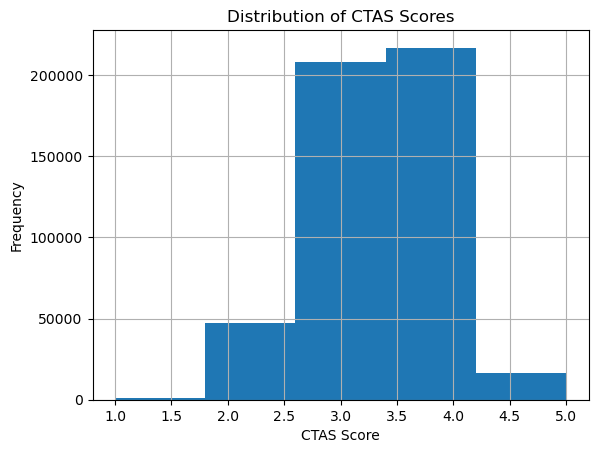

count    489354.000000
mean          3.410899
std           0.717459
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: CTAS, dtype: float64


In [100]:
# Next missing values are in the case of CTAS column 

# Histogram to see the distribution of CTAS scores
df_event_log_visits['CTAS'].hist(bins=5)
plt.title('Distribution of CTAS Scores')
plt.xlabel('CTAS Score')
plt.ylabel('Frequency')
plt.show()

# Descriptive statistics
print(df_event_log_visits['CTAS'].describe())


In [101]:
# Check for rows where CTAS is missing
missing_ctas_df = df_event_log_visits[df_event_log_visits['CTAS'].isna()]

# Display how many of these have 'TLWBS' or 'RLWBS' as the depart_disposition_id
missing_ctas_dispositions = missing_ctas_df['DEPART_DISPOSITION_ID'].value_counts()
print(missing_ctas_dispositions)


DEPART_DISPOSITION_ID
ADM      2772
D        2751
RLWBS     857
TLWBS     538
TTO       345
AMA        18
EXP        14
TL          7
ITLBC       3
Name: count, dtype: int64


In [102]:

# Calculate the total counts of each DEPART_DISPOSITION_ID in the whole dataset
total_dispositions = df_event_log_visits['DEPART_DISPOSITION_ID'].value_counts()

# Calculate proportions for the missing CTAS group
missing_ctas_proportions = missing_ctas_dispositions / missing_ctas_dispositions.sum()

# Calculate proportions for the whole dataset
total_proportions = total_dispositions / total_dispositions.sum()

# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame({
    'Missing_CTAS_Proportion': missing_ctas_proportions,
    'Total_Proportion': total_proportions
})

# Display the DataFrame
print(comparison_df)


                       Missing_CTAS_Proportion  Total_Proportion
DEPART_DISPOSITION_ID                                           
ADM                                   0.379466          0.083094
ALBT                                       NaN          0.000349
AMA                                   0.002464          0.001123
D                                     0.376591          0.796064
DOA                                        NaN          0.000006
DS                                         NaN          0.000125
EXP                                   0.001916          0.000708
ITLBC                                 0.000411          0.002845
RLWBS                                 0.117317          0.002927
TA                                         NaN          0.000663
TC                                         NaN          0.000147
TCC                                        NaN          0.000038
TGSL                                       NaN          0.000008
TL                       

After imputation, remaining missing values in 'CTAS': 0


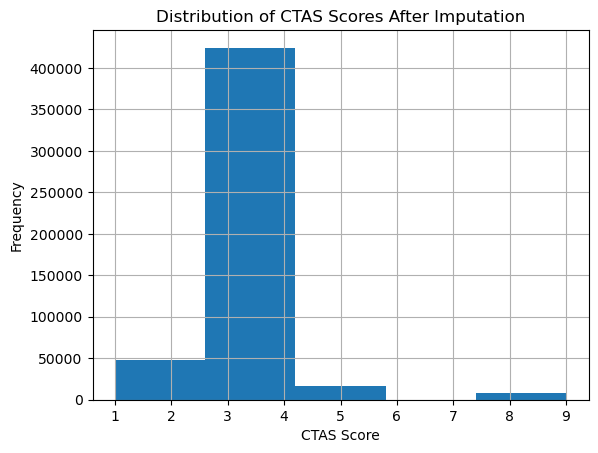

In [103]:
# A significant proportion of 'RLWBS' (25.02%) and 'TLWBS' (6.41%) is in the missing CTAS dataset, this is higher compared
# to their proportions in the entire dataset (0.26% and 10.80% respectively). I will code it “9”.

# Coding missing CTAS values as 9
df_event_log_visits['CTAS'].fillna(9, inplace=True)


# Verifying no missing values
print(f"After imputation, remaining missing values in 'CTAS': {df_event_log_visits['CTAS'].isnull().sum()}")

# the distribution after imputation
df_event_log_visits['CTAS'].hist(bins=5)
plt.title('Distribution of CTAS Scores After Imputation')
plt.xlabel('CTAS Score')
plt.ylabel('Frequency')
plt.show()

In [104]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 497852 entries, 0 to 497855
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      497852 non-null  object 
 1   SEX                      497852 non-null  object 
 2   DOB                      497852 non-null  object 
 3   DOD                      27730 non-null   object 
 4   ED_POSTAL_CODE           497852 non-null  object 
 5   FACILITY_ID              497852 non-null  object 
 6   FACILITY_NAME            497852 non-null  object 
 7   VISIT_ID                 497852 non-null  object 
 8   VISIT_AGE                497852 non-null  float64
 9   CTAS                     497852 non-null  float64
 10  REASON_FOR_VISIT         493068 non-null  object 
 11  PRESENTING_COMPLAINT     496609 non-null  object 
 12  DEPART_DISPOSITION_ID    496027 non-null  object 
 13  DEPART_DISPOSITION_DESC  496027 non-null  object 
 14  Activity 

## REASON_FOR_VISIT 

In [105]:
df_event_log_visits['REASON_FOR_VISIT'].nunique()

38425

In [106]:
## too many values - decided to drop the column  
df_event_log_visits.drop(columns=['REASON_FOR_VISIT'], inplace=True)


## PRESENTING_COMPLAINT 

In [107]:
df_event_log_visits['PRESENTING_COMPLAINT'].nunique()

177

In [108]:
# Drop rows with missing values in the PRESENTING_COMPLAINT column
df_event_log_visits.dropna(subset=['PRESENTING_COMPLAINT'], inplace=True)


In [109]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496609 entries, 0 to 497855
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      496609 non-null  object 
 1   SEX                      496609 non-null  object 
 2   DOB                      496609 non-null  object 
 3   DOD                      27356 non-null   object 
 4   ED_POSTAL_CODE           496609 non-null  object 
 5   FACILITY_ID              496609 non-null  object 
 6   FACILITY_NAME            496609 non-null  object 
 7   VISIT_ID                 496609 non-null  object 
 8   VISIT_AGE                496609 non-null  float64
 9   CTAS                     496609 non-null  float64
 10  PRESENTING_COMPLAINT     496609 non-null  object 
 11  DEPART_DISPOSITION_ID    494784 non-null  object 
 12  DEPART_DISPOSITION_DESC  494784 non-null  object 
 13  Activity                 496609 non-null  object 
 14  TIME_OF_T

## DEPART_DISPOSITION_ID

In [110]:
# Departing disposition is one of the values I will be predicting with the model 
# (TRIAGED LEFT W/O BEING SEEN and REGISTERED LEFT W/O BEING SEEN)
# hence I decided to not deal with the missing values at this moment - however, we only need one of the columns
df_event_log_visits['DEPART_DISPOSITION_DESC'].unique()

array(['DISCHARGED W/O SUPPORT SERV', 'ADMITTED',
       'TRIAGED LEFT W/O BEING SEEN', 'TRANSFER TO OTHER',
       'REGISTERED LEFT W/O BEING SEEN', 'INIT RX LEFT BEFORE COMPLETE',
       'TRANSFER TO OTHER ACUTE CARE', 'LEFT AGAINST MEDICAL ADVICE', nan,
       'DIED IN FACILITY', 'ASSESSED LEFT BEFORE TREATMENT',
       'TRANSFER TO CONTINUING CARE', 'DISCHARGED WITH SUPPORT SERV',
       'TRANSFER TO LONG TERM CARE', 'DOA',
       'TRSF TO CORRECTIONAL FACILITY', 'TRANSFER TO GROUP SUPP LIVING'],
      dtype=object)

In [111]:
df_event_log_visits.drop(['DEPART_DISPOSITION_DESC'], axis=1, inplace=True)

In [112]:
dispositions_counts =  df_event_log_visits['DEPART_DISPOSITION_ID'].value_counts()

# Print the counts
print(dispositions_counts)

DEPART_DISPOSITION_ID
D        394793
TLWBS     49570
ADM       40075
TTO        5678
RLWBS      1452
ITLBC      1411
AMA         557
EXP         351
TA          329
TL          234
ALBT        173
TC           73
DS           62
TCC          19
TGSL          4
DOA           3
Name: count, dtype: int64


# 3) Preprocessing columns
In the next steps I am preprocessing and cleaning data in all columns that will be used by the deep learning model.

## SEX

In [113]:
# preprocessing the SEX column

df_event_log_visits['SEX'].value_counts()

SEX
F    271988
M    224560
U        61
Name: count, dtype: int64

In [114]:
# Encode 'M' as 0 and 'F' as 1 and 'U' as 2
df_event_log_visits['SEX'] = df_event_log_visits['SEX'].map({'M': 0, 'F': 1, 'U': 2})
df_event_log_visits

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,PRESENTING_COMPLAINT,DEPART_DISPOSITION_ID,Activity,TIME_OF_THE_DAY,Start_Time,Activity_End_Time,Duration_hours
0,STDY147061,1,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,SHORTNESS OF BREATH,D,Triage,Early Morning to Morning,2022-04-01 00:22:00+00:00,2022-04-01 00:22:00+00:00,0.550000
1,STDY147061,1,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,SHORTNESS OF BREATH,D,Providing service,Early Morning to Morning,2022-04-01 00:22:00+00:00,2022-04-01 00:24:00+00:00,0.550000
2,STDY147061,1,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,SHORTNESS OF BREATH,D,Assessment,Early Morning to Morning,2022-04-01 00:24:00+00:00,2022-04-01 00:30:00+00:00,0.550000
3,STDY147061,1,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,SHORTNESS OF BREATH,D,Patient departed,Early Morning to Morning,2022-04-01 00:30:00+00:00,2022-04-01 00:55:00+00:00,0.550000
4,STDY321073,0,1999-02-08,NaN,A1B1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,LOWER EXTREMITY INJURY,D,Triage,Early Morning to Morning,2022-04-01 00:40:00+00:00,2022-04-01 00:40:00+00:00,5.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497851,STDY586460,1,1989-07-22,NaN,A1B0G5,HSC,Health Sciences Centre - St. Johns,VISIT2377969,33.750000,4.0,"LUMP,BUMPS,CALLUSES",TLWBS,Patient departed,Evening to Night,2023-04-30 23:51:00+00:00,2023-05-01 02:30:00+00:00,2.750000
497852,STDY258323,1,1961-03-12,NaN,A1E3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,COUGH/CONGESTION,D,Triage,Evening to Night,2023-04-30 23:45:00+00:00,2023-04-30 23:45:00+00:00,8.233333
497853,STDY258323,1,1961-03-12,NaN,A1E3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,COUGH/CONGESTION,D,Providing service,Evening to Night,2023-04-30 23:45:00+00:00,2023-04-30 23:52:00+00:00,8.233333
497854,STDY258323,1,1961-03-12,NaN,A1E3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,COUGH/CONGESTION,D,Assessment,Evening to Night,2023-04-30 23:52:00+00:00,2023-05-01 07:50:00+00:00,8.233333


## DATE OF BIRTH

In [115]:
# preprocessing the DOB column

# converting the 'DOB' column to datetime
df_event_log_visits['DOB'] = pd.to_datetime(df_event_log_visits['DOB'])


## PRESENTING_COMPLAINT

In [116]:

from sklearn.preprocessing import LabelEncoder


# Apply label encoding
label_encoder = LabelEncoder()
df_event_log_visits['PRESENTING_COMPLAINT_ENCODED'] = label_encoder.fit_transform(df_event_log_visits['PRESENTING_COMPLAINT'])

# Drop the original PRESENTING_COMPLAINT column
df_event_log_visits.drop(columns=['PRESENTING_COMPLAINT'], inplace=True)

df_event_log_visits.head(5)

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,DEPART_DISPOSITION_ID,Activity,TIME_OF_THE_DAY,Start_Time,Activity_End_Time,Duration_hours,PRESENTING_COMPLAINT_ENCODED
0,STDY147061,1,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,Triage,Early Morning to Morning,2022-04-01 00:22:00+00:00,2022-04-01 00:22:00+00:00,0.550000,141
1,STDY147061,1,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,Providing service,Early Morning to Morning,2022-04-01 00:22:00+00:00,2022-04-01 00:24:00+00:00,0.550000,141
2,STDY147061,1,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,Assessment,Early Morning to Morning,2022-04-01 00:24:00+00:00,2022-04-01 00:30:00+00:00,0.550000,141
3,STDY147061,1,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,Patient departed,Early Morning to Morning,2022-04-01 00:30:00+00:00,2022-04-01 00:55:00+00:00,0.550000,141
4,STDY321073,0,1999-02-08,NaN,A1B1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,D,Triage,Early Morning to Morning,2022-04-01 00:40:00+00:00,2022-04-01 00:40:00+00:00,5.333333,94


## 3.1) Creating new features based on the old features
Here, I am creating new features based on the available features in the dataset.

## DATE OF DEATH and IS_DECEASED

In [117]:
# Preprocessing the DOD column by creating a binary indicator from DOD
df_event_log_visits['Is_Deceased'] = df_event_log_visits['DOD'].notnull().astype(int)

df_event_log_visits['DOD'] = pd.to_datetime(df_event_log_visits['DOD'], errors='coerce')

df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496609 entries, 0 to 497855
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   SID                           496609 non-null  object        
 1   SEX                           496609 non-null  int64         
 2   DOB                           496609 non-null  datetime64[ns]
 3   DOD                           27356 non-null   datetime64[ns]
 4   ED_POSTAL_CODE                496609 non-null  object        
 5   FACILITY_ID                   496609 non-null  object        
 6   FACILITY_NAME                 496609 non-null  object        
 7   VISIT_ID                      496609 non-null  object        
 8   VISIT_AGE                     496609 non-null  float64       
 9   CTAS                          496609 non-null  float64       
 10  DEPART_DISPOSITION_ID         494784 non-null  object        
 11  Activity          

In [118]:

# inspecting the unique values in 'DEPART_DISPOSITION_ID' when 'Is_Deceased' is True
deceased_dispositions = df_event_log_visits[df_event_log_visits['Is_Deceased'] == 1]['DEPART_DISPOSITION_ID'].value_counts()

# A cross-tabulation to see the relationship more clearly
crosstab = pd.crosstab(df_event_log_visits['Is_Deceased'], df_event_log_visits['DEPART_DISPOSITION_ID'])

print("Distribution of departure dispositions for deceased cases:")
print(deceased_dispositions)

print("\nCross-tabulation of 'Is_Deceased' and 'DEPART_DISPOSITION_ID':")
print(crosstab)


Distribution of departure dispositions for deceased cases:
DEPART_DISPOSITION_ID
D        15255
ADM       9211
TLWBS     1047
TTO        797
EXP        351
ITLBC      107
AMA         68
TL          53
TA          43
RLWBS       33
DOA          3
TC           3
Name: count, dtype: int64

Cross-tabulation of 'Is_Deceased' and 'DEPART_DISPOSITION_ID':
DEPART_DISPOSITION_ID    ADM  ALBT  AMA       D  DOA  DS  EXP  ITLBC  RLWBS  \
Is_Deceased                                                                   
0                      30864   173  489  379538    0  62    0   1304   1419   
1                       9211     0   68   15255    3   0  351    107     33   

DEPART_DISPOSITION_ID   TA  TC  TCC  TGSL   TL  TLWBS   TTO  
Is_Deceased                                                  
0                      286  70   19     4  181  48523  4881  
1                       43   3    0     0   53   1047   797  


In [119]:

df_event_log_visits['DOD'] = pd.to_datetime(df_event_log_visits['DOD'], errors='coerce').dt.tz_localize(None).dt.tz_localize('UTC')

# comparisons
df_event_log_visits['Died_Before_Visit'] = (df_event_log_visits['DOD'] < df_event_log_visits['Start_Time']).astype(int)
df_event_log_visits['Died_During_Visit'] = ((df_event_log_visits['DOD'] >= df_event_log_visits['Start_Time']) & 
                                            (df_event_log_visits['DOD'] <= df_event_log_visits['Activity_End_Time'])).astype(int)
df_event_log_visits['Died_After_Visit'] = (df_event_log_visits['DOD'] > df_event_log_visits['Activity_End_Time']).astype(int)


In [120]:
# Filtering for rows where 'Is_Deceased' is 1 and display the first few rows
deceased_visits = df_event_log_visits[df_event_log_visits['Is_Deceased'] == 1]
deceased_visits.head()


,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Activity,TIME_OF_THE_DAY,Start_Time,Activity_End_Time,Duration_hours,PRESENTING_COMPLAINT_ENCODED,Is_Deceased,Died_Before_Visit,Died_During_Visit,Died_After_Visit
35,STDY293268,0,1945-10-26,2023-04-15 00:00:00+00:00,A1C2B5,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2208415,76.500000,4.0,...,Triage,Early Morning to Morning,2022-04-01 02:50:00+00:00,2022-04-01 02:50:00+00:00,4.0,147,1,0,0,1
36,STDY293268,0,1945-10-26,2023-04-15 00:00:00+00:00,A1C2B5,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2208415,76.500000,4.0,...,Providing service,Early Morning to Morning,2022-04-01 02:50:00+00:00,2022-04-01 02:59:00+00:00,4.0,147,1,0,0,1
37,STDY293268,0,1945-10-26,2023-04-15 00:00:00+00:00,A1C2B5,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2208415,76.500000,4.0,...,Assessment,Early Morning to Morning,2022-04-01 02:59:00+00:00,2022-04-01 06:30:00+00:00,4.0,147,1,0,0,1
38,STDY293268,0,1945-10-26,2023-04-15 00:00:00+00:00,A1C2B5,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2208415,76.500000,4.0,...,Patient departed,Early Morning to Morning,2022-04-01 06:30:00+00:00,2022-04-01 06:50:00+00:00,4.0,147,1,0,0,1
247,STDY327615,0,1963-08-25,2022-04-04 00:00:00+00:00,A1B5C4,HSC,Health Sciences Centre - St. Johns,VISIT2208489,58.666667,3.0,...,Triage,Late Morning to Late Afternoon,2022-04-01 09:30:00+00:00,2022-04-01 09:30:00+00:00,8.0,18,1,0,0,1


In [121]:
# checking counts:
died_before_visit_count = df_event_log_visits[df_event_log_visits['Died_Before_Visit'] == 1].shape[0]
print("Number of cases where death occurred before the visit:", died_before_visit_count)

died_during_visit_count = df_event_log_visits[df_event_log_visits['Died_During_Visit'] == 1].shape[0]
print("Number of cases where death occurred during the visit:", died_during_visit_count)

died_after_visit_count = df_event_log_visits[df_event_log_visits['Died_After_Visit'] == 1].shape[0]
print("Number of cases where death occurred after the visit:", died_after_visit_count)


Number of cases where death occurred before the visit: 611
Number of cases where death occurred during the visit: 692
Number of cases where death occurred after the visit: 26053


## AREA_TYPE

In [122]:
# identifying rural or urban area based on the postal code according to
# https://www.canadapost-postescanada.ca/cpc/en/support/articles/addressing-guidelines/postal-codes.page

# Function to determine if a postal code is urban or rural
def urban_rural_classifier(postal_code):
    # Check the second character of the postal code
    if postal_code[1] == '0':
        return 'rural'
    else:
        return 'urban'

# Apply the function to classify each postal code
df_event_log_visits['Area_Type'] = df_event_log_visits['ED_POSTAL_CODE'].apply(urban_rural_classifier)

# Verify by displaying the DataFrame
print(df_event_log_visits[['ED_POSTAL_CODE', 'Area_Type']].head())

  ED_POSTAL_CODE Area_Type
0         A0A2B0     rural
1         A0A2B0     rural
2         A0A2B0     rural
3         A0A2B0     rural
4         A1B1Z6     urban


In [123]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496609 entries, 0 to 497855
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           496609 non-null  object             
 1   SEX                           496609 non-null  int64              
 2   DOB                           496609 non-null  datetime64[ns]     
 3   DOD                           27356 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                496609 non-null  object             
 5   FACILITY_ID                   496609 non-null  object             
 6   FACILITY_NAME                 496609 non-null  object             
 7   VISIT_ID                      496609 non-null  object             
 8   VISIT_AGE                     496609 non-null  float64            
 9   CTAS                          496609 non-null  float64            
 10  DEPART_DISPOSITION_ID    

## COORDINATES

In [124]:
# adding latutide and longitude table from geonames
file_path = 'CA_full.txt'
postal_codes = pd.read_csv(file_path, delimiter='\t', names=[
    'Country', 'Postal_Code', 'Place_Name', 'Province', 'Province_Code',
    'Unnamed5', 'Unnamed6', 'Unnamed7', 'Unnamed8', 'Latitude', 'Longitude', 'Extra'
], skiprows=1)  # skiprows=1 to skip the example header row you pasted

# Dropping the unnecessary columns
postal_codes.drop(columns=['Unnamed5', 'Unnamed6', 'Unnamed7', 'Unnamed8', 'Extra'], inplace=True)

# Displaying the dataframe to ensure it loaded correctly
print(postal_codes.head())


  Country Postal_Code    Place_Name Province Province_Code  Latitude  \
0      CA     T0A 0A1   Saddle Lake  Alberta            AB   54.0029   
1      CA     T0A 0A2  Cherry Grove  Alberta            AB   54.3603   
2      CA     T0A 0A3       Glendon  Alberta            AB   54.3455   
3      CA     T0A 0A4     Lindbergh  Alberta            AB   54.3455   
4      CA     T0A 0A5       St Lina  Alberta            AB   54.3455   

   Longitude  
0  -111.7000  
1  -110.0863  
2  -111.6157  
3  -111.6157  
4  -111.6157  


In [125]:
# checking for duplicates 

print(postal_codes['Postal_Code'].duplicated().sum())
postal_codes = postal_codes.drop_duplicates(subset=['Postal_Code'], keep='first')


891


In [126]:
# Merging the dataframes
df_event_log_visits = df_event_log_visits.merge(postal_codes, left_on='ED_POSTAL_CODE', right_on='Postal_Code', how='left')

# Checking for missing latitude and longitude after the merge
print(df_event_log_visits[['Latitude', 'Longitude']].isnull().sum())


Latitude     495457
Longitude    495457
dtype: int64


In [127]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           496609 non-null  object             
 1   SEX                           496609 non-null  int64              
 2   DOB                           496609 non-null  datetime64[ns]     
 3   DOD                           27356 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                496609 non-null  object             
 5   FACILITY_ID                   496609 non-null  object             
 6   FACILITY_NAME                 496609 non-null  object             
 7   VISIT_ID                      496609 non-null  object             
 8   VISIT_AGE                     496609 non-null  float64            
 9   CTAS                          496609 non-null  float64            
 10  DEPART_DISPOSITION_I

In [128]:
# some of the postal codes can not be found on geonames as they are - the closest coordinates can be found by using
# only the first three digits
postal_codes['First_3_Digits'] = postal_codes['Postal_Code'].str[:3]


In [129]:
# rows where 'Latitude' or 'Longitude' is missing 
df_event_log_visits_missing_lat = df_event_log_visits[df_event_log_visits['Latitude'].isnull() | df_event_log_visits['Longitude'].isnull()]

# creating nnew column
df_event_log_visits_missing_lat['First_3_Digits'] = df_event_log_visits['ED_POSTAL_CODE'].str[:3]
df_event_log_visits_missing_lat

C:\Users\ksteflova\AppData\Local\Temp\ipykernel_8532\2478119479.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event_log_visits_missing_lat['First_3_Digits'] = df_event_log_visits['ED_POSTAL_CODE'].str[:3]


,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Died_After_Visit,Area_Type,Country,Postal_Code,Place_Name,Province,Province_Code,Latitude,Longitude,First_3_Digits
0,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A
1,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A
2,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A
3,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A
4,STDY321073,0,1999-02-08,NaT,A1B1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496604,STDY586460,1,1989-07-22,NaT,A1B0G5,HSC,Health Sciences Centre - St. Johns,VISIT2377969,33.750000,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1B
496605,STDY258323,1,1961-03-12,NaT,A1E3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1E
496606,STDY258323,1,1961-03-12,NaT,A1E3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1E
496607,STDY258323,1,1961-03-12,NaT,A1E3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1E


In [130]:

# Optimize data types
df_event_log_visits_missing_lat['First_3_Digits'] = df_event_log_visits_missing_lat['First_3_Digits'].astype('category')
postal_codes['First_3_Digits'] = postal_codes['First_3_Digits'].astype('category')

# Select only relevant columns for the merge
df_event_log_visits_missing_lat = df_event_log_visits_missing_lat[['First_3_Digits']]
postal_codes = postal_codes[['First_3_Digits', 'Latitude', 'Longitude']]

# Perform the merge
df_merged = df_event_log_visits_missing_lat.merge(postal_codes, on='First_3_Digits', how='left', suffixes=('', '_pc'))

# Display the merged DataFrame
print(df_merged.head())


C:\Users\ksteflova\AppData\Local\Temp\ipykernel_8532\2549043629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event_log_visits_missing_lat['First_3_Digits'] = df_event_log_visits_missing_lat['First_3_Digits'].astype('category')


  First_3_Digits  Latitude  Longitude
0            A0A   47.4234   -53.1966
1            A0A   47.3856   -53.1341
2            A0A   46.7372   -53.3638
3            A0A   47.5370   -53.2699
4            A0A   47.9437   -53.0682


In [131]:
# adding new column to the original dataset to merge on
df_event_log_visits['First_3_Digits'] = df_event_log_visits['ED_POSTAL_CODE'].str[:3]
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Died_After_Visit,Area_Type,Country,Postal_Code,Place_Name,Province,Province_Code,Latitude,Longitude,First_3_Digits
0,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A
1,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A
2,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A
3,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A
4,STDY321073,0,1999-02-08,NaT,A1B1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1B


In [132]:
# Find the rows in the main dataset where latitude and longitude are missing
missing_indices = df_event_log_visits[df_event_log_visits['Latitude'].isna() & df_event_log_visits['Longitude'].isna()].index

# Update the main dataset with the latitude and longitude from the merged DataFrame
df_event_log_visits.loc[missing_indices, 'Latitude'] = df_merged['Latitude']
df_event_log_visits.loc[missing_indices, 'Longitude'] = df_merged['Longitude']

# Check if the missing values are updated
print(df_event_log_visits.loc[missing_indices, ['First_3_Digits', 'Latitude', 'Longitude']])


       First_3_Digits  Latitude  Longitude
0                 A0A   47.4234   -53.1966
1                 A0A   47.3856   -53.1341
2                 A0A   46.7372   -53.3638
3                 A0A   47.5370   -53.2699
4                 A1B   47.9437   -53.0682
...               ...       ...        ...
496604            A1B   47.6068   -52.7137
496605            A1E   47.6068   -52.7137
496606            A1E   47.6068   -52.7137
496607            A1E   47.6068   -52.7137
496608            A1E   47.6068   -52.7137

[495457 rows x 3 columns]


In [133]:
# an overview of all missing values in the DataFrame
print(df_event_log_visits.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 30 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           496609 non-null  object             
 1   SEX                           496609 non-null  int64              
 2   DOB                           496609 non-null  datetime64[ns]     
 3   DOD                           27356 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                496609 non-null  object             
 5   FACILITY_ID                   496609 non-null  object             
 6   FACILITY_NAME                 496609 non-null  object             
 7   VISIT_ID                      496609 non-null  object             
 8   VISIT_AGE                     496609 non-null  float64            
 9   CTAS                          496609 non-null  float64            
 10  DEPART_DISPOSITION_I

In [134]:
# Dropping rows where either Latitude or Longitude is missing (3 rows)
df_event_log_visits = df_event_log_visits.dropna(subset=['Latitude', 'Longitude'])

# Verifying the result
print(df_event_log_visits[['Latitude', 'Longitude']].isnull().sum())


Latitude     0
Longitude    0
dtype: int64


In [135]:

# Assuming 'First_3_Digits' represents the first 3 digits of postal codes

# List of postal codes corresponding to Conception Bay ('A1X', 'A1W' - CBS , 'A0A', 'A1Y' - CBN)
conception_bay_postal_codes = ['A1X', 'A1W', 'A0A', 'A1Y']

# Filter the dataset for Conception Bay postal codes
cbn_data = df_event_log_visits[df_event_log_visits['First_3_Digits'].isin(conception_bay_postal_codes)]

# Create a cross-tabulation of postal codes with hospital sites
cross_tab = pd.crosstab(cbn_data['First_3_Digits'], cbn_data['FACILITY_NAME'])

# Output the cross-tabulation
cross_tab


FACILITY_NAME,Burin Peninsula Health care Centre - Burin,Carbonear General Hospital - Carbonear,Dr. G.B. Cross Memorial Hospital - Clarenville,Health Sciences Centre - St. Johns,St. Clares Mercy Hospital - St. Johns
First_3_Digits,,,,,
A0A,106,57985,414,13232,10679
A1W,40,153,101,6952,3636
A1X,55,305,126,11116,5767
A1Y,8,20038,56,676,240


## DISTANCE_TO_HOSPITAL

In [136]:
from geopy.distance import geodesic

# Hospital coordinates dictionary (includes all hospitals)
hospital_coords = {
    'Health Sciences Centre - St. Johns': (47.57173844188426, -52.7428752808959),
    'St. Clares Mercy Hospital - St. Johns': (47.55783035337661, -52.72164112844875),
    'Dr. G.B. Cross Memorial Hospital - Clarenville': (48.165186482963676, -53.98449946306605),
    'Carbonear General Hospital - Carbonear': (47.725414948091, -53.226560474732224),
    'Burin Peninsula Health care Centre - Burin': (47.10500591911938, -55.19465935942642),  
}

# Calculating the distance between a case and a hospital
def calculate_distance(row, hospital_name):
    case_coords = (row['Latitude'], row['Longitude'])
    hospital_coords_tuple = hospital_coords.get(hospital_name, None)  
    if hospital_coords_tuple is None:
        return float('nan')  # Return NaN if the hospital isn't in the dictionary
    return geodesic(case_coords, hospital_coords_tuple).km  # Distance in kilometers

# Applying the function to calculate distances for all hospitals
df_event_log_visits['Distance_to_Hospital'] = df_event_log_visits.apply(
    lambda row: calculate_distance(row, row['FACILITY_NAME']),
    axis=1
)

# Displaying DataFrame with the calculated distances
print(df_event_log_visits[['VISIT_ID', 'FACILITY_NAME', 'Distance_to_Hospital']].head())


       VISIT_ID                           FACILITY_NAME  Distance_to_Hospital
0  VISIT2208402  Carbonear General Hospital - Carbonear             33.654212
1  VISIT2208402  Carbonear General Hospital - Carbonear             38.416728
2  VISIT2208402  Carbonear General Hospital - Carbonear            110.355548
3  VISIT2208402  Carbonear General Hospital - Carbonear             21.200279
4  VISIT2208404      Health Sciences Centre - St. Johns             48.013427


## IS_NL_HOLIDAY

In [137]:
# List of Newfoundland and Labrador holidays in "MM-DD" format
nl_holidays = {
    "01-01",  # New Year's Day
    "03-17",  # St. Patrick's Day
    "04-23",  # St. George's Day
    "06-24",  # Discovery Day
    "07-01",  # Canada Day
    "09-02",  # Labour Day
    "10-14",  # Thanksgiving
    "11-11",  # Remembrance Day
    "12-25",  # Christmas Day
    "12-26"   # Boxing Day
}

# checking if a given date matches a holiday
def is_nl_holiday(date):
    # Extracting month and day from the date
    month_day = date.strftime("%m-%d")
    return month_day in nl_holidays


In [138]:
# Converting 'Start_Time' to datetime 
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])

# Applying the function to create a new column
df_event_log_visits['Is_NL_Holiday'] = df_event_log_visits['Start_Time'].apply(is_nl_holiday)

# Displaying results
print(df_event_log_visits[['Start_Time', 'Is_NL_Holiday']].head())



                 Start_Time  Is_NL_Holiday
0 2022-04-01 00:22:00+00:00          False
1 2022-04-01 00:22:00+00:00          False
2 2022-04-01 00:24:00+00:00          False
3 2022-04-01 00:30:00+00:00          False
4 2022-04-01 00:40:00+00:00          False


## DAY_OF_WEEK and IS_WEEKEND

In [139]:
# Getting the day of the week (0 = Monday, 6 = Sunday)
df_event_log_visits['Day_of_Week'] = pd.to_datetime(df_event_log_visits['Start_Time']).dt.dayofweek
df_event_log_visits['Is_Weekend'] = df_event_log_visits['Day_of_Week'].isin([5, 6])


In [140]:
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Place_Name,Province,Province_Code,Latitude,Longitude,First_3_Digits,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend
0,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NaN,NaN,NaN,47.4234,-53.1966,A0A,33.654212,False,4,False
1,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NaN,NaN,NaN,47.3856,-53.1341,A0A,38.416728,False,4,False
2,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NaN,NaN,NaN,46.7372,-53.3638,A0A,110.355548,False,4,False
3,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NaN,NaN,NaN,47.5370,-53.2699,A0A,21.200279,False,4,False
4,STDY321073,0,1999-02-08,NaT,A1B1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,NaN,NaN,NaN,47.9437,-53.0682,A1B,48.013427,False,4,False


## VISIT_SEASON

In [141]:
# Defining season ranges
seasons = {
    "Winter": (1, 2, 12),
    "Spring": (3, 4, 5),
    "Summer": (6, 7, 8),
    "Fall": (9, 10, 11)
}

# Function to get the season
def get_season(month):
    for season, months in seasons.items():
        if month in months:
            return season
    return None

df_event_log_visits['Visit_Season'] = df_event_log_visits['Start_Time'].apply(
    lambda x: get_season(pd.to_datetime(x).month)
)


In [142]:
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Province,Province_Code,Latitude,Longitude,First_3_Digits,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend,Visit_Season
0,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NaN,NaN,47.4234,-53.1966,A0A,33.654212,False,4,False,Spring
1,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NaN,NaN,47.3856,-53.1341,A0A,38.416728,False,4,False,Spring
2,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NaN,NaN,46.7372,-53.3638,A0A,110.355548,False,4,False,Spring
3,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NaN,NaN,47.5370,-53.2699,A0A,21.200279,False,4,False,Spring
4,STDY321073,0,1999-02-08,NaT,A1B1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,NaN,NaN,47.9437,-53.0682,A1B,48.013427,False,4,False,Spring


## VISIT_FREQUENCY

In [143]:
# Ensuring 'Start_Time' is in datetime format
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])

# Sorting the data
df_event_log_visits.sort_values(by=['SID', 'Start_Time'], inplace=True)

# Identifying the latest visit for each SID
df_event_log_visits['Latest_Visit'] = df_event_log_visits.groupby('SID')['Start_Time'].transform('max')

# Marking rows that correspond to the latest visit
df_event_log_visits['Is_Latest_Visit'] = df_event_log_visits['Start_Time'] == df_event_log_visits['Latest_Visit']

# Counting all unique visits per SID
visit_counts = df_event_log_visits.groupby('SID')['VISIT_ID'].nunique()

# Subtracting 1 from the counts to exclude the current visit (where there are previous visits)
visit_counts = visit_counts - 1

# Ensuring that no negative counts are present (in cases with only one visit)
visit_counts = visit_counts.clip(lower=0)

# Mapping the adjusted visit counts back to the original DataFrame
df_event_log_visits['Visit_Frequency'] = df_event_log_visits['SID'].map(visit_counts)

# Display the result
print(df_event_log_visits[['SID', 'VISIT_ID', 'Visit_Frequency']].head())


               SID      VISIT_ID  Visit_Frequency
402002  STDY111126  VISIT2345092                1
402003  STDY111126  VISIT2345092                1
402004  STDY111126  VISIT2345092                1
402005  STDY111126  VISIT2345092                1
428256  STDY111126  VISIT2354278                1


In [144]:
df_event_log_visits.drop(columns=['Latest_Visit', 'Is_Latest_Visit'], inplace=True)


In [145]:
df_event_log_visits.describe()

,SEX,DOB,VISIT_AGE,CTAS,Duration_hours,PRESENTING_COMPLAINT_ENCODED,Is_Deceased,Died_Before_Visit,Died_During_Visit,Died_After_Visit,Latitude,Longitude,Distance_to_Hospital,Day_of_Week,Visit_Frequency
count,496609.000000,496609,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.00000,496609.000000,496609.000000,496609.000000
mean,0.547936,1972-09-19 20:47:42.694796096,50.053571,3.507739,23.648712,86.038898,0.055086,0.001230,0.001393,0.052462,47.560918,-53.10944,66.590442,2.902835,2.721143
min,0.000000,1917-04-13 00:00:00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.272500,-78.89380,0.027117,0.000000,0.000000
25%,0.000000,1954-10-16 00:00:00,32.166667,3.000000,2.133333,32.000000,0.000000,0.000000,0.000000,0.000000,47.524200,-52.84430,4.354943,1.000000,0.000000
50%,1.000000,1971-01-23 00:00:00,51.750000,3.000000,4.083333,92.000000,0.000000,0.000000,0.000000,0.000000,47.556300,-52.75830,19.883559,3.000000,1.000000
75%,1.000000,1990-07-26 00:00:00,68.000000,4.000000,7.183333,141.000000,0.000000,0.000000,0.000000,0.000000,47.586400,-52.71950,104.331203,5.000000,3.000000
max,2.000000,2023-03-27 00:00:00,106.000000,9.000000,4829.850000,176.000000,1.000000,1.000000,1.000000,1.000000,62.416700,-52.66080,2281.546466,6.000000,123.000000
std,0.497944,NaN,21.864583,1.015147,107.281563,55.453569,0.228147,0.035055,0.037303,0.222957,0.410082,1.96286,155.289194,1.995314,6.928266


In [146]:
# 'TLWBS' and 'RLWBS' codes indicate left without being seen
lwbs_codes = ['TLWBS', 'RLWBS']
df_event_log_visits['Is_LWBS'] = df_event_log_visits['DEPART_DISPOSITION_ID'].isin(lwbs_codes).astype(int)



In [147]:

df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])

# Sorting the DataFrame by 'SID' and 'Start_Time'
df_event_log_visits.sort_values(by=['SID', 'Start_Time'], inplace=True)

# Identifying the last visit for each SID
df_event_log_visits['Latest_Visit'] = df_event_log_visits.groupby('SID')['Start_Time'].transform('max')

# Excluding the latest visit from counting
condition = df_event_log_visits['Start_Time'] < df_event_log_visits['Latest_Visit']
df_prior_visits = df_event_log_visits[condition]

# Summing up LWBS occurrences per visit, excluding the latest visit
lwbs_per_visit = df_prior_visits.groupby(['SID', 'VISIT_ID'])['Is_LWBS'].max().groupby('SID').cumsum().reset_index()

# Renaming the column in lwbs_per_visit before merging
lwbs_per_visit.rename(columns={'Is_LWBS': 'Prior_LWBS'}, inplace=True)

# Merging this cumulative count back to the original DataFrame on both SID and VISIT_ID
df_event_log_visits = df_event_log_visits.merge(lwbs_per_visit, on=['SID', 'VISIT_ID'], how='left', suffixes=('', '_cumulative'))

# Replacing NaN with 0 for visits without any prior LWBS events
df_event_log_visits['Prior_LWBS'].fillna(0, inplace=True)

# Dropping the temporary column if no longer needed
df_event_log_visits.drop(columns='Latest_Visit', inplace=True)

# Display the DataFrame to verify results
print(df_event_log_visits[['SID', 'VISIT_ID', 'Prior_LWBS']].head())


          SID      VISIT_ID  Prior_LWBS
0  STDY111126  VISIT2345092         0.0
1  STDY111126  VISIT2345092         0.0
2  STDY111126  VISIT2345092         0.0
3  STDY111126  VISIT2345092         0.0
4  STDY111126  VISIT2354278         1.0


In [148]:
# Filtering rows for SID 'STDY111131' and displaying specific columns
filtered_rows = df_event_log_visits[df_event_log_visits['SID'] == 'STDY111131']
print(filtered_rows[['SID', 'VISIT_ID', 'Prior_LWBS', 'DEPART_DISPOSITION_ID']])


           SID      VISIT_ID  Prior_LWBS DEPART_DISPOSITION_ID
7   STDY111131  VISIT2233914         0.0                     D
8   STDY111131  VISIT2233914         0.0                     D
9   STDY111131  VISIT2233914         0.0                     D
10  STDY111131  VISIT2233914         0.0                     D
11  STDY111131  VISIT2234433         0.0                     D
12  STDY111131  VISIT2234433         0.0                     D
13  STDY111131  VISIT2234433         0.0                     D
14  STDY111131  VISIT2234433         0.0                     D


In [149]:
df_event_log_visits.columns

Index(['SID', 'SEX', 'DOB', 'DOD', 'ED_POSTAL_CODE', 'FACILITY_ID',
       'FACILITY_NAME', 'VISIT_ID', 'VISIT_AGE', 'CTAS',
       'DEPART_DISPOSITION_ID', 'Activity', 'TIME_OF_THE_DAY', 'Start_Time',
       'Activity_End_Time', 'Duration_hours', 'PRESENTING_COMPLAINT_ENCODED',
       'Is_Deceased', 'Died_Before_Visit', 'Died_During_Visit',
       'Died_After_Visit', 'Area_Type', 'Country', 'Postal_Code', 'Place_Name',
       'Province', 'Province_Code', 'Latitude', 'Longitude', 'First_3_Digits',
       'Distance_to_Hospital', 'Is_NL_Holiday', 'Day_of_Week', 'Is_Weekend',
       'Visit_Season', 'Visit_Frequency', 'Is_LWBS', 'Prior_LWBS'],
      dtype='object')

In [150]:
df_event_log_visits.describe()

,SEX,DOB,VISIT_AGE,CTAS,Duration_hours,PRESENTING_COMPLAINT_ENCODED,Is_Deceased,Died_Before_Visit,Died_During_Visit,Died_After_Visit,Latitude,Longitude,Distance_to_Hospital,Day_of_Week,Visit_Frequency,Is_LWBS,Prior_LWBS
count,496609.000000,496609,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.00000,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000
mean,0.547936,1972-09-19 20:47:42.694796096,50.053571,3.507739,23.648712,86.038898,0.055086,0.001230,0.001393,0.052462,47.560918,-53.10944,66.590442,2.902835,2.721143,0.102741,0.343596
min,0.000000,1917-04-13 00:00:00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.272500,-78.89380,0.027117,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1954-10-16 00:00:00,32.166667,3.000000,2.133333,32.000000,0.000000,0.000000,0.000000,0.000000,47.524200,-52.84430,4.354943,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1971-01-23 00:00:00,51.750000,3.000000,4.083333,92.000000,0.000000,0.000000,0.000000,0.000000,47.556300,-52.75830,19.883559,3.000000,1.000000,0.000000,0.000000
75%,1.000000,1990-07-26 00:00:00,68.000000,4.000000,7.183333,141.000000,0.000000,0.000000,0.000000,0.000000,47.586400,-52.71950,104.331203,5.000000,3.000000,0.000000,0.000000
max,2.000000,2023-03-27 00:00:00,106.000000,9.000000,4829.850000,176.000000,1.000000,1.000000,1.000000,1.000000,62.416700,-52.66080,2281.546466,6.000000,123.000000,1.000000,48.000000
std,0.497944,NaN,21.864583,1.015147,107.281563,55.453569,0.228147,0.035055,0.037303,0.222957,0.410082,1.96286,155.289194,1.995314,6.928266,0.303620,1.530461


## ED_BUSINESS_HOURLY

In [151]:

# Groupping by hour to get the number of patient arrivals in each hour
arrival_counts = df_event_log_visits.groupby(df_event_log_visits['Start_Time'].dt.floor('H')).size()

# Mappinng the hourly counts back to the original DataFrame
df_event_log_visits['ED_Business_Hourly'] = df_event_log_visits['Start_Time'].dt.floor('H').map(arrival_counts)


print(df_event_log_visits[['Start_Time', 'ED_Business_Hourly']].head())


                 Start_Time  ED_Business_Hourly
0 2023-02-09 09:51:01+00:00                  88
1 2023-02-09 09:51:01+00:00                  88
2 2023-02-09 09:51:02+00:00                  88
3 2023-02-09 09:53:00+00:00                  88
4 2023-03-04 23:08:00+00:00                  36


In [152]:

df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,First_3_Digits,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend,Visit_Season,Visit_Frequency,Is_LWBS,Prior_LWBS,ED_Business_Hourly
0,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,A0B,48.507660,False,3,False,Winter,1,0,0.0,88
1,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,A0B,20.435879,False,3,False,Winter,1,0,0.0,88
2,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,A0B,15.742262,False,3,False,Winter,1,0,0.0,88
3,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,A0B,29.234594,False,3,False,Winter,1,0,0.0,88
4,STDY111126,1,1997-01-19,NaT,A0B3K0,HSC,Health Sciences Centre - St. Johns,VISIT2354278,26.166667,3.0,...,A0B,3.660683,False,5,True,Spring,1,1,1.0,36


In [153]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 39 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           496609 non-null  object             
 1   SEX                           496609 non-null  int64              
 2   DOB                           496609 non-null  datetime64[ns]     
 3   DOD                           27356 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                496609 non-null  object             
 5   FACILITY_ID                   496609 non-null  object             
 6   FACILITY_NAME                 496609 non-null  object             
 7   VISIT_ID                      496609 non-null  object             
 8   VISIT_AGE                     496609 non-null  float64            
 9   CTAS                          496609 non-null  float64            
 10  DEPART_DISPOSITION_I

##  The acuity score for each hour for each site 

In [154]:
# Convert Start_Time and Activity_End_Time to datetime 
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])
df_event_log_visits['Activity_End_Time'] = pd.to_datetime(df_event_log_visits['Activity_End_Time'])


In [155]:
# Calculate Inverse_CTAS
df_event_log_visits['Inverse_CTAS'] = 1 / df_event_log_visits['CTAS']


In [156]:

# Initialize an empty DataFrame to store acuity scores
acuity_scores = pd.DataFrame()

In [157]:
# Iterate through each facility
for facility in df_event_log_visits['FACILITY_ID'].unique():
    # Filter data for the current facility
    facility_data = df_event_log_visits[df_event_log_visits['FACILITY_ID'] == facility]
    
    # Create an hourly index for the time span covered by the facility's data
    # hourly_index: This is a range of timestamps, 
    # starting from start_time and ending at end_time, with a frequency of 1 hour (freq='H').
    # This hourly index includes both the date and time components for each hour in the specified range.

    start_time = facility_data['Start_Time'].min()
    end_time = facility_data['Activity_End_Time'].max()
    hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')
    
    # Initialize a list to hold the active cases per hour
    hourly_acuity = []
    
    # Determine active cases for each hour
    for hour in hourly_index:
        # Filter the data to get active cases at the current hour - A case is considered active if the Start_Time is before or at the hour,
        # and the Activity_End_Time is after or at the hour.
        active_cases = facility_data[(facility_data['Start_Time'] <= hour) & 
                                     (facility_data['Activity_End_Time'] >= hour)]
        # Calculate the mean Inverse_CTAS for active cases
        if not active_cases.empty:
            mean_inverse_ctas = active_cases['Inverse_CTAS'].mean()
        else:
            mean_inverse_ctas = 0
        
    
        # Append the result to the list
        hourly_acuity.append({
            'FACILITY_ID': facility,
            'Hour': hour,
            'Inverse_CTAS': mean_inverse_ctas
        })
    
    # Convert the list to a DataFrame and append it to the acuity_scores DataFrame
    facility_acuity_df = pd.DataFrame(hourly_acuity)
    acuity_scores = pd.concat([acuity_scores, facility_acuity_df], ignore_index=True)


In [158]:
# checking the hourly index values to confirm
hourly_index

DatetimeIndex(['2022-04-01 09:09:01+00:00', '2022-04-01 10:09:01+00:00',
               '2022-04-01 11:09:01+00:00', '2022-04-01 12:09:01+00:00',
               '2022-04-01 13:09:01+00:00', '2022-04-01 14:09:01+00:00',
               '2022-04-01 15:09:01+00:00', '2022-04-01 16:09:01+00:00',
               '2022-04-01 17:09:01+00:00', '2022-04-01 18:09:01+00:00',
               ...
               '2023-05-15 02:09:01+00:00', '2023-05-15 03:09:01+00:00',
               '2023-05-15 04:09:01+00:00', '2023-05-15 05:09:01+00:00',
               '2023-05-15 06:09:01+00:00', '2023-05-15 07:09:01+00:00',
               '2023-05-15 08:09:01+00:00', '2023-05-15 09:09:01+00:00',
               '2023-05-15 10:09:01+00:00', '2023-05-15 11:09:01+00:00'],
              dtype='datetime64[ns, UTC]', length=9819, freq='H')

In [168]:
acuity_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50246 entries, 0 to 50245
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   FACILITY_ID   50246 non-null  object             
 1   Hour          50246 non-null  datetime64[ns, UTC]
 2   Inverse_CTAS  50246 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 1.2+ MB


In [167]:
# Save the acuity_scores DataFrame to a CSV file
acuity_scores.to_csv('acuity_scores.csv', index=False)

In [159]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 40 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           496609 non-null  object             
 1   SEX                           496609 non-null  int64              
 2   DOB                           496609 non-null  datetime64[ns]     
 3   DOD                           27356 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                496609 non-null  object             
 5   FACILITY_ID                   496609 non-null  object             
 6   FACILITY_NAME                 496609 non-null  object             
 7   VISIT_ID                      496609 non-null  object             
 8   VISIT_AGE                     496609 non-null  float64            
 9   CTAS                          496609 non-null  float64            
 10  DEPART_DISPOSITION_I

In [160]:
# Ensure 'Hour' is a datetime column in the original dataset
df_event_log_visits['Hour'] = df_event_log_visits['Start_Time'].dt.floor('H')


In [161]:
# Floor the 'Hour' columns in both dataframes to the nearest hour
df_event_log_visits['Hour'] = df_event_log_visits['Hour'].dt.floor('H')
acuity_scores['Hour'] = acuity_scores['Hour'].dt.floor('H')

# Ensure the combination of FACILITY_ID and Hour is unique in acuity_scores
acuity_scores_unique = acuity_scores.groupby(['FACILITY_ID', 'Hour'], as_index=False)['Inverse_CTAS'].mean()

# Merge datasets
merged_df = pd.merge(df_event_log_visits, acuity_scores_unique, how='left', on=['FACILITY_ID', 'Hour'])

# Inspect missing values
missing_values = merged_df[merged_df['Inverse_CTAS_y'].isnull()]
print("Sample missing values in merged_df:")
print(missing_values[['FACILITY_ID', 'Hour']].head(10))


Sample missing values in merged_df:
Empty DataFrame
Columns: [FACILITY_ID, Hour]
Index: []


In [162]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 42 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           496609 non-null  object             
 1   SEX                           496609 non-null  int64              
 2   DOB                           496609 non-null  datetime64[ns]     
 3   DOD                           27356 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                496609 non-null  object             
 5   FACILITY_ID                   496609 non-null  object             
 6   FACILITY_NAME                 496609 non-null  object             
 7   VISIT_ID                      496609 non-null  object             
 8   VISIT_AGE                     496609 non-null  float64            
 9   CTAS                          496609 non-null  float64            
 10  DEPART_DISPOSITION_I

In [164]:
# Dropping the column that is not needed based on my analysis
merged_df.drop(columns=['Inverse_CTAS_x','Hour' ], inplace=True)


In [165]:

merged_df.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend,Visit_Season,Visit_Frequency,Is_LWBS,Prior_LWBS,ED_Business_Hourly,Inverse_CTAS_y
0,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,48.507660,False,3,False,Winter,1,0,0.0,88,0.375000
1,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,20.435879,False,3,False,Winter,1,0,0.0,88,0.375000
2,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,15.742262,False,3,False,Winter,1,0,0.0,88,0.375000
3,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,29.234594,False,3,False,Winter,1,0,0.0,88,0.375000
4,STDY111126,1,1997-01-19,NaT,A0B3K0,HSC,Health Sciences Centre - St. Johns,VISIT2354278,26.166667,3.0,...,3.660683,False,5,True,Spring,1,1,1.0,36,0.341421


In [166]:
df_event_log_visits = merged_df
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 40 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           496609 non-null  object             
 1   SEX                           496609 non-null  int64              
 2   DOB                           496609 non-null  datetime64[ns]     
 3   DOD                           27356 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                496609 non-null  object             
 5   FACILITY_ID                   496609 non-null  object             
 6   FACILITY_NAME                 496609 non-null  object             
 7   VISIT_ID                      496609 non-null  object             
 8   VISIT_AGE                     496609 non-null  float64            
 9   CTAS                          496609 non-null  float64            
 10  DEPART_DISPOSITION_I

## Acuity Standard Deviation per 2 hours

In [181]:

# Ensure 'Start_Time' is datetime if it's not already
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])

# Sort by FACILITY_ID and Start_Time to ensure proper rolling calculations
df_event_log_visits = df_event_log_visits.sort_values(by=['FACILITY_ID', 'Start_Time'])

# Define the rolling window size
window_size = 2

# Group by FACILITY_ID and apply rolling window calculation for Std_Inverse_CTAS
df_event_log_visits['Rolling_Std_Inverse_CTAS'] = df_event_log_visits.groupby('FACILITY_ID')['Inverse_CTAS_y'].rolling(window=window_size, min_periods=1).std().reset_index(level=0, drop=True)

# Verify the calculated statistics
print(df_event_log_visits[['FACILITY_ID', 'Start_Time', 'Inverse_CTAS_y', 'Rolling_Std_Inverse_CTAS']].head())



       FACILITY_ID                Start_Time  Inverse_CTAS_y  \
403793         BUR 2022-04-01 09:09:01+00:00            0.25   
403794         BUR 2022-04-01 09:09:01+00:00            0.25   
403795         BUR 2022-04-01 09:09:02+00:00            0.25   
165798         BUR 2022-04-01 09:17:01+00:00            0.25   
165799         BUR 2022-04-01 09:17:01+00:00            0.25   

        Rolling_Std_Inverse_CTAS  
403793                       NaN  
403794                       0.0  
403795                       0.0  
165798                       0.0  
165799                       0.0  


In [183]:

df_event_log_visits.describe()

,SEX,DOB,VISIT_AGE,CTAS,Duration_hours,PRESENTING_COMPLAINT_ENCODED,Is_Deceased,Died_Before_Visit,Died_During_Visit,Died_After_Visit,Latitude,Longitude,Distance_to_Hospital,Day_of_Week,Visit_Frequency,Is_LWBS,Prior_LWBS,ED_Business_Hourly,Inverse_CTAS_y,Rolling_Std_Inverse_CTAS
count,496609.000000,496609,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.00000,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496609.000000,496604.000000
mean,0.547936,1972-09-19 20:47:42.694796080,50.053571,3.507739,23.648712,86.038898,0.055086,0.001230,0.001393,0.052462,47.560918,-53.10944,66.590442,2.902835,2.721143,0.102741,0.343596,68.491725,0.339050,0.000328
min,0.000000,1917-04-13 00:00:00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.272500,-78.89380,0.027117,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,1954-10-16 00:00:00,32.166667,3.000000,2.133333,32.000000,0.000000,0.000000,0.000000,0.000000,47.524200,-52.84430,4.354943,1.000000,0.000000,0.000000,0.000000,49.000000,0.328320,0.000000
50%,1.000000,1971-01-23 00:00:00,51.750000,3.000000,4.083333,92.000000,0.000000,0.000000,0.000000,0.000000,47.556300,-52.75830,19.883559,3.000000,1.000000,0.000000,0.000000,70.000000,0.342287,0.000000
75%,1.000000,1990-07-26 00:00:00,68.000000,4.000000,7.183333,141.000000,0.000000,0.000000,0.000000,0.000000,47.586400,-52.71950,104.331203,5.000000,3.000000,0.000000,0.000000,88.000000,0.355556,0.000000
max,2.000000,2023-03-27 00:00:00,106.000000,9.000000,4829.850000,176.000000,1.000000,1.000000,1.000000,1.000000,62.416700,-52.66080,2281.546466,6.000000,123.000000,1.000000,48.000000,162.000000,0.500000,0.235702
std,0.497944,NaN,21.864583,1.015147,107.281563,55.453569,0.228147,0.035055,0.037303,0.222957,0.410082,1.96286,155.289194,1.995314,6.928266,0.303620,1.530461,27.524807,0.027563,0.002127


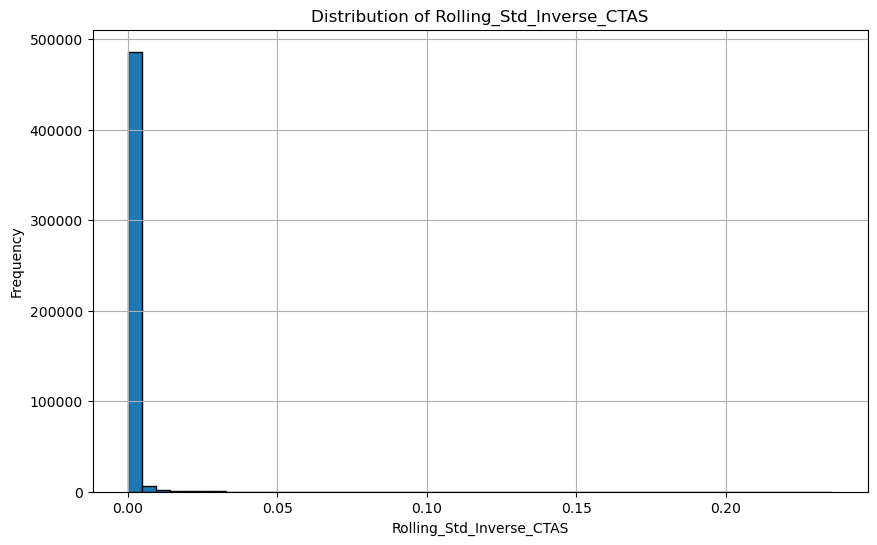

In [184]:
# Plot the distribution of Rolling_Std_Inverse_CTAS
plt.figure(figsize=(10, 6))
df_event_log_visits['Rolling_Std_Inverse_CTAS'].plot(kind='hist', bins=50, edgecolor='k')
plt.title('Distribution of Rolling_Std_Inverse_CTAS')
plt.xlabel('Rolling_Std_Inverse_CTAS')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [185]:
# Calculate the median of Rolling_Std_Inverse_CTAS
median_std = df_event_log_visits['Rolling_Std_Inverse_CTAS'].median()
print(f'Median of Rolling_Std_Inverse_CTAS: {median_std}')

# Fill NaN values in Rolling_Std_Inverse_CTAS with the median
df_event_log_visits['Rolling_Std_Inverse_CTAS'].fillna(median_std, inplace=True)

# Verify that there are no more NaN values
print(df_event_log_visits['Rolling_Std_Inverse_CTAS'].isna().sum())



Median of Rolling_Std_Inverse_CTAS: 0.0
0


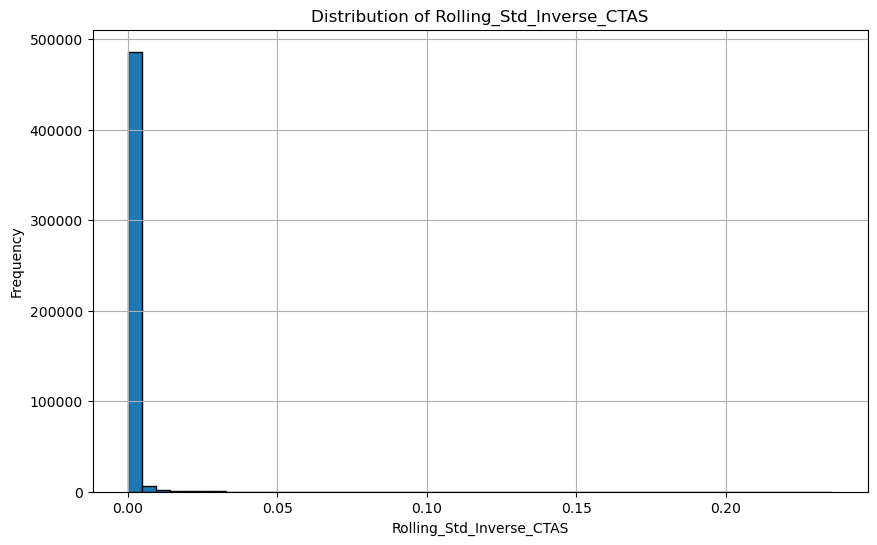

In [186]:
# Plot the distribution of Rolling_Std_Inverse_CTAS
plt.figure(figsize=(10, 6))
df_event_log_visits['Rolling_Std_Inverse_CTAS'].plot(kind='hist', bins=50, edgecolor='k')
plt.title('Distribution of Rolling_Std_Inverse_CTAS')
plt.xlabel('Rolling_Std_Inverse_CTAS')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Mean Age per hour

In [187]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496609 entries, 403793 to 338272
Data columns (total 42 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           496609 non-null  object             
 1   SEX                           496609 non-null  int64              
 2   DOB                           496609 non-null  datetime64[ns]     
 3   DOD                           27356 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                496609 non-null  object             
 5   FACILITY_ID                   496609 non-null  object             
 6   FACILITY_NAME                 496609 non-null  object             
 7   VISIT_ID                      496609 non-null  object             
 8   VISIT_AGE                     496609 non-null  float64            
 9   CTAS                          496609 non-null  float64            
 10  DEPART_DISPOSITION_I

In [188]:

df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])

# Extract the hour from 'Start_Time' to facilitate grouping
df_event_log_visits['Hour'] = df_event_log_visits['Start_Time'].dt.floor('H')

# Group by 'FACILITY_ID' and 'Hour' to calculate the mean age
mean_age_per_hour = df_event_log_visits.groupby(['FACILITY_ID', 'Hour']).agg(
    Mean_Age=('VISIT_AGE', 'mean')
).reset_index()

# Verify the calculated statistics
print(mean_age_per_hour.head())




  FACILITY_ID                      Hour   Mean_Age
0         BUR 2022-04-01 09:00:00+00:00  32.138889
1         BUR 2022-04-01 10:00:00+00:00  72.619048
2         BUR 2022-04-01 14:00:00+00:00  59.666667
3         BUR 2022-04-01 15:00:00+00:00  14.791667
4         BUR 2022-04-01 16:00:00+00:00   2.416667


In [189]:
mean_age_per_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41191 entries, 0 to 41190
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   FACILITY_ID  41191 non-null  object             
 1   Hour         41191 non-null  datetime64[ns, UTC]
 2   Mean_Age     41191 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 965.5+ KB


In [190]:

# Convert 'Hour' to datetime if it's not already
mean_age_per_hour['Hour'] = pd.to_datetime(mean_age_per_hour['Hour'])

# Merge the mean age back into the original dataframe based on FACILITY_ID and Hour
df_event_log_visits = pd.merge(df_event_log_visits, mean_age_per_hour, on=['FACILITY_ID', 'Hour'], how='left')
df_event_log_visits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 43 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           496609 non-null  object             
 1   SEX                           496609 non-null  int64              
 2   DOB                           496609 non-null  datetime64[ns]     
 3   DOD                           27356 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                496609 non-null  object             
 5   FACILITY_ID                   496609 non-null  object             
 6   FACILITY_NAME                 496609 non-null  object             
 7   VISIT_ID                      496609 non-null  object             
 8   VISIT_AGE                     496609 non-null  float64            
 9   CTAS                          496609 non-null  float64            
 10  DEPART_DISPOSITION_I

In [191]:
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Is_Weekend,Visit_Season,Visit_Frequency,Is_LWBS,Prior_LWBS,ED_Business_Hourly,Inverse_CTAS_y,Hour,Rolling_Std_Inverse_CTAS,Mean_Age
0,STDY356576,1,2019-11-29,NaT,A0E2V0,BUR,Burin Peninsula Health care Centre - Burin,VISIT2208476,2.416667,4.0,...,False,Spring,4,0,0.0,94,0.25,2022-04-01 09:00:00+00:00,0.0,32.138889
1,STDY356576,1,2019-11-29,NaT,A0E2V0,BUR,Burin Peninsula Health care Centre - Burin,VISIT2208476,2.416667,4.0,...,False,Spring,4,0,0.0,94,0.25,2022-04-01 09:00:00+00:00,0.0,32.138889
2,STDY356576,1,2019-11-29,NaT,A0E2V0,BUR,Burin Peninsula Health care Centre - Burin,VISIT2208476,2.416667,4.0,...,False,Spring,4,0,0.0,94,0.25,2022-04-01 09:00:00+00:00,0.0,32.138889
3,STDY210431,1,1994-05-09,NaT,A0E3A0,BUR,Burin Peninsula Health care Centre - Burin,VISIT2208482,27.916667,9.0,...,False,Spring,1,1,1.0,94,0.25,2022-04-01 09:00:00+00:00,0.0,32.138889
4,STDY210431,1,1994-05-09,NaT,A0E3A0,BUR,Burin Peninsula Health care Centre - Burin,VISIT2208482,27.916667,9.0,...,False,Spring,1,1,1.0,94,0.25,2022-04-01 09:00:00+00:00,0.0,32.138889


## Number of unique presenting complaints per hour

In [192]:
# Ensure 'Start_Time' is datetime if it's not already
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])

# Extract the hour from 'Start_Time' to facilitate grouping
df_event_log_visits['Hour'] = df_event_log_visits['Start_Time'].dt.floor('H')

# Group by 'FACILITY_ID' and 'Hour' to calculate the number of unique presenting complaints
unique_presenting_complaints_per_hour = df_event_log_visits.groupby(['FACILITY_ID', 'Hour']).agg(
    Unique_Presenting_Complaints=('PRESENTING_COMPLAINT_ENCODED', 'nunique')
).reset_index()

# Verify the calculated statistics
print(unique_presenting_complaints_per_hour.head())



  FACILITY_ID                      Hour  Unique_Presenting_Complaints
0         BUR 2022-04-01 09:00:00+00:00                             3
1         BUR 2022-04-01 10:00:00+00:00                             2
2         BUR 2022-04-01 14:00:00+00:00                             1
3         BUR 2022-04-01 15:00:00+00:00                             2
4         BUR 2022-04-01 16:00:00+00:00                             1


In [193]:

# Convert 'Hour' to datetime if it's not already
unique_presenting_complaints_per_hour['Hour'] = pd.to_datetime(unique_presenting_complaints_per_hour['Hour'])

# Merge the number of unique presenting complaints back into the original dataframe based on FACILITY_ID and Hour
df_event_log_visits = pd.merge(df_event_log_visits, unique_presenting_complaints_per_hour, on=['FACILITY_ID', 'Hour'], how='left')

df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 44 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           496609 non-null  object             
 1   SEX                           496609 non-null  int64              
 2   DOB                           496609 non-null  datetime64[ns]     
 3   DOD                           27356 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                496609 non-null  object             
 5   FACILITY_ID                   496609 non-null  object             
 6   FACILITY_NAME                 496609 non-null  object             
 7   VISIT_ID                      496609 non-null  object             
 8   VISIT_AGE                     496609 non-null  float64            
 9   CTAS                          496609 non-null  float64            
 10  DEPART_DISPOSITION_I

## IMAGING_DONE and LABS_DONE

In [194]:
# Loading the Excel file for imaging data
imaging_data = pd.read_excel("October2023_Data\INC10447_ED_VISIT_IMAGES_20230929.xlsx")

# Loading the CSV file for lab tests data
labs_data = pd.read_csv("October2023_Data\INC10447_ED_VISIT_LABS_20230929.csv")

# Displaying the first few rows to ensure correct data loading
print("Imaging Data:")
print(imaging_data.head())
print("Labs Data:")
print(labs_data.head())

Imaging Data:
          SID   ED_VISIT_ID ED_SERVICE_DATE IMAGE_REPORTED_DATE  \
0  STDY111111  VISIT2102120      2021-07-12          2021-07-12   
1  STDY111113  VISIT1942974      2020-05-26          2020-05-27   
2  STDY111113  VISIT1942974      2020-05-26          2020-05-27   
3  STDY111115  VISIT1996593      2020-10-08          2020-10-08   
4  STDY111116  VISIT1424440      2017-03-19          2017-03-19   

     IMAGE_TEST_NAME  
0  CHEST DUAL ENERGY  
1          HAND LEFT  
2      SCAPHOID LEFT  
3          FOOT LEFT  
4   CHEST PA+LATERAL  
Labs Data:
          SID   ED_VISIT_ID ED_SERVICE_DATE LAB_REPORTED_DATE    LAB_TEST_NAME
0  STDY111111  VISIT2102120     12-JUL-2021       12-JUL-2021        ANION GAP
1  STDY111111  VISIT2102120     12-JUL-2021       12-JUL-2021  BILIRUBIN;TOTAL
2  STDY111111  VISIT2102120     12-JUL-2021       12-JUL-2021              CBC
3  STDY111111  VISIT2102120     12-JUL-2021       12-JUL-2021         CHLORIDE
4  STDY111111  VISIT2102120     12-JUL-

In [195]:
# Convert the date columns to datetime type
imaging_data['ED_SERVICE_DATE'] = pd.to_datetime(imaging_data['ED_SERVICE_DATE'])
imaging_data['IMAGE_REPORTED_DATE'] = pd.to_datetime(imaging_data['IMAGE_REPORTED_DATE'])
labs_data['ED_SERVICE_DATE'] = pd.to_datetime(labs_data['ED_SERVICE_DATE'])
labs_data['LAB_REPORTED_DATE'] = pd.to_datetime(labs_data['LAB_REPORTED_DATE'])

# Define the date range
start_date = '2022-04-01'
end_date = '2023-04-30'

# Filter the Imaging Data
filtered_imaging_data = imaging_data[
    (imaging_data['ED_SERVICE_DATE'] >= start_date) & 
    (imaging_data['ED_SERVICE_DATE'] <= end_date)
]

# Filter the Labs Data
filtered_labs_data = labs_data[
    (labs_data['ED_SERVICE_DATE'] >= start_date) & 
    (labs_data['ED_SERVICE_DATE'] <= end_date)
]

# Check the filtered data
print("Filtered Imaging Data:", filtered_imaging_data.head())
print("Filtered Labs Data:", filtered_labs_data.head())


C:\Users\ksteflova\AppData\Local\Temp\ipykernel_8532\2150560135.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  labs_data['ED_SERVICE_DATE'] = pd.to_datetime(labs_data['ED_SERVICE_DATE'])
C:\Users\ksteflova\AppData\Local\Temp\ipykernel_8532\2150560135.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  labs_data['LAB_REPORTED_DATE'] = pd.to_datetime(labs_data['LAB_REPORTED_DATE'])


Filtered Imaging Data:            SID   ED_VISIT_ID ED_SERVICE_DATE IMAGE_REPORTED_DATE  \
31  STDY111131  VISIT2234433      2022-05-31          2022-05-31   
32  STDY111131  VISIT2234433      2022-05-31          2022-05-31   
35  STDY111135  VISIT2323052      2022-12-17          2022-12-17   
36  STDY111135  VISIT2361850      2023-03-23          2023-03-23   
56  STDY111151  VISIT2342133      2023-02-01          2023-02-01   

                  IMAGE_TEST_NAME  
31                   SPINE LUMBAR  
32                 SPINE THORACIC  
35  HEAD COMPLEX WITHOUT CONTRAST  
36              CHEST DUAL ENERGY  
56      VEIN LOWER EXTREMITY LEFT  
Filtered Labs Data:             SID   ED_VISIT_ID ED_SERVICE_DATE LAB_REPORTED_DATE  \
284  STDY111131  VISIT2234433      2022-05-31        2022-05-31   
324  STDY111135  VISIT2323052      2022-12-17        2022-12-17   
325  STDY111135  VISIT2323052      2022-12-17        2022-12-17   
326  STDY111135  VISIT2323052      2022-12-17        2022-12-17 

In [196]:
filtered_imaging_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68030 entries, 31 to 473181
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SID                  68030 non-null  object        
 1   ED_VISIT_ID          68030 non-null  object        
 2   ED_SERVICE_DATE      68030 non-null  datetime64[ns]
 3   IMAGE_REPORTED_DATE  68030 non-null  datetime64[ns]
 4   IMAGE_TEST_NAME      68030 non-null  object        
dtypes: datetime64[ns](2), object(3)
memory usage: 3.1+ MB


In [197]:
filtered_labs_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 792076 entries, 284 to 4877967
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   SID                792076 non-null  object        
 1   ED_VISIT_ID        792076 non-null  object        
 2   ED_SERVICE_DATE    792076 non-null  datetime64[ns]
 3   LAB_REPORTED_DATE  792076 non-null  datetime64[ns]
 4   LAB_TEST_NAME      792076 non-null  object        
dtypes: datetime64[ns](2), object(3)
memory usage: 36.3+ MB


In [198]:
import pandas as pd


# Find unique image test names
unique_images = filtered_imaging_data['IMAGE_TEST_NAME'].unique()

# Find unique lab test names
unique_labs = filtered_labs_data['LAB_TEST_NAME'].unique()

print(f"Unique image test names: {len(unique_images)}")
print(f"Unique lab test names: {len(unique_labs)}")


Unique image test names: 417
Unique lab test names: 411


In [199]:
# Group by visit ID and count the number of tests and images
image_counts = filtered_imaging_data.groupby('ED_VISIT_ID').size()
lab_counts = filtered_labs_data.groupby('ED_VISIT_ID').size()

# Calculate min, max, and average for image tests
image_min = image_counts.min()
image_max = image_counts.max()
image_avg = image_counts.mean()

# Calculate min, max, and average for lab tests
lab_min = lab_counts.min()
lab_max = lab_counts.max()
lab_avg = lab_counts.mean()

print(f"Image tests - Min: {image_min}, Max: {image_max}, Avg: {image_avg:.2f}")
print(f"Lab tests - Min: {lab_min}, Max: {lab_max}, Avg: {lab_avg:.2f}")


Image tests - Min: 1, Max: 13, Avg: 1.40
Lab tests - Min: 1, Max: 389, Avg: 11.88


In [200]:
# Aggregate Imaging Data by visit
imaging_summary = filtered_imaging_data.groupby(['SID', 'ED_VISIT_ID'])['IMAGE_TEST_NAME'].agg([
    ('Imaging_Tests', lambda x: ', '.join(x.unique())),  # Concatenate unique test names
    ('Num_Imaging_Tests', 'nunique')                     # Count unique tests
]).reset_index()

# Aggregate Labs Data by visit
labs_summary = filtered_labs_data.groupby(['SID', 'ED_VISIT_ID'])['LAB_TEST_NAME'].agg([
    ('Lab_Tests', lambda x: ', '.join(x.unique())),       # Concatenate unique lab names
    ('Num_Lab_Tests', 'nunique')                          # Count unique labs
]).reset_index()

# Merge the summaries with the main dataset
df_event_log_visits = df_event_log_visits.merge(imaging_summary, how='left', left_on=['SID', 'VISIT_ID'], right_on=['SID', 'ED_VISIT_ID'])
df_event_log_visits = df_event_log_visits.merge(labs_summary, how='left', left_on=['SID', 'VISIT_ID'], right_on=['SID', 'ED_VISIT_ID'])

# Clean up the merged DataFrame
df_event_log_visits.drop(columns=['ED_VISIT_ID_x', 'ED_VISIT_ID_y'], inplace=True)

# Replace NaNs in new columns with appropriate defaults
df_event_log_visits[['Imaging_Tests', 'Lab_Tests']].fillna('None', inplace=True)
df_event_log_visits[['Num_Imaging_Tests', 'Num_Lab_Tests']].fillna(0, inplace=True)

# Display to verify
print(df_event_log_visits.head())


          SID  SEX        DOB DOD ED_POSTAL_CODE FACILITY_ID  \
0  STDY356576    1 2019-11-29 NaT         A0E2V0         BUR   
1  STDY356576    1 2019-11-29 NaT         A0E2V0         BUR   
2  STDY356576    1 2019-11-29 NaT         A0E2V0         BUR   
3  STDY210431    1 1994-05-09 NaT         A0E3A0         BUR   
4  STDY210431    1 1994-05-09 NaT         A0E3A0         BUR   

                                FACILITY_NAME      VISIT_ID  VISIT_AGE  CTAS  \
0  Burin Peninsula Health care Centre - Burin  VISIT2208476   2.416667   4.0   
1  Burin Peninsula Health care Centre - Burin  VISIT2208476   2.416667   4.0   
2  Burin Peninsula Health care Centre - Burin  VISIT2208476   2.416667   4.0   
3  Burin Peninsula Health care Centre - Burin  VISIT2208482  27.916667   9.0   
4  Burin Peninsula Health care Centre - Burin  VISIT2208482  27.916667   9.0   

   ... ED_Business_Hourly Inverse_CTAS_y                      Hour  \
0  ...                 94           0.25 2022-04-01 09:00:00+00:

C:\Users\ksteflova\AppData\Local\Temp\ipykernel_8532\3929436199.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event_log_visits[['Imaging_Tests', 'Lab_Tests']].fillna('None', inplace=True)
C:\Users\ksteflova\AppData\Local\Temp\ipykernel_8532\3929436199.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event_log_visits[['Num_Imaging_Tests', 'Num_Lab_Tests']].fillna(0, inplace=True)


In [201]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 48 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           496609 non-null  object             
 1   SEX                           496609 non-null  int64              
 2   DOB                           496609 non-null  datetime64[ns]     
 3   DOD                           27356 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                496609 non-null  object             
 5   FACILITY_ID                   496609 non-null  object             
 6   FACILITY_NAME                 496609 non-null  object             
 7   VISIT_ID                      496609 non-null  object             
 8   VISIT_AGE                     496609 non-null  float64            
 9   CTAS                          496609 non-null  float64            
 10  DEPART_DISPOSITION_I

In [202]:
# Check in the Imaging Data
imaging_presence = filtered_imaging_data[filtered_imaging_data['ED_VISIT_ID'] == 'VISIT2354278']

# Check in the Labs Data
labs_presence = filtered_labs_data[filtered_labs_data['ED_VISIT_ID'] == 'VISIT2354278']

# Print the results
print("Imaging Data:")
print(imaging_presence)
print("\nLabs Data:")
print(labs_presence)




Imaging Data:
Empty DataFrame
Columns: [SID, ED_VISIT_ID, ED_SERVICE_DATE, IMAGE_REPORTED_DATE, IMAGE_TEST_NAME]
Index: []

Labs Data:
Empty DataFrame
Columns: [SID, ED_VISIT_ID, ED_SERVICE_DATE, LAB_REPORTED_DATE, LAB_TEST_NAME]
Index: []


In [203]:
# Check in the Imaging Data
imaging_presence = filtered_imaging_data[filtered_imaging_data['ED_VISIT_ID'] == 'VISIT2234433']

# Check in the Labs Data
labs_presence = filtered_labs_data[filtered_labs_data['ED_VISIT_ID'] == 'VISIT2234433']

# Print the results
print("Imaging Data:")
print(imaging_presence)
print("\nLabs Data:")
print(labs_presence)




Imaging Data:
           SID   ED_VISIT_ID ED_SERVICE_DATE IMAGE_REPORTED_DATE  \
31  STDY111131  VISIT2234433      2022-05-31          2022-05-31   
32  STDY111131  VISIT2234433      2022-05-31          2022-05-31   

   IMAGE_TEST_NAME  
31    SPINE LUMBAR  
32  SPINE THORACIC  

Labs Data:
            SID   ED_VISIT_ID ED_SERVICE_DATE LAB_REPORTED_DATE  \
284  STDY111131  VISIT2234433      2022-05-31        2022-05-31   

        LAB_TEST_NAME  
284  URINALYSIS PANEL  


In [204]:
# Filter the DataFrame for the specific VISIT_ID
filtered_data = df_event_log_visits[df_event_log_visits['VISIT_ID'] == 'VISIT2234433']

# Display the filtered DataFrame
filtered_data


,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,ED_Business_Hourly,Inverse_CTAS_y,Hour,Rolling_Std_Inverse_CTAS,Mean_Age,Unique_Presenting_Complaints,Imaging_Tests,Num_Imaging_Tests,Lab_Tests,Num_Lab_Tests
235124,STDY111131,1,2000-05-02,NaT,A0E1P0,HSC,Health Sciences Centre - St. Johns,VISIT2234433,22.0,4.0,...,121,0.352431,2022-05-31 08:00:00+00:00,0.0,47.781250,15,"SPINE LUMBAR, SPINE THORACIC",2.0,URINALYSIS PANEL,1.0
235125,STDY111131,1,2000-05-02,NaT,A0E1P0,HSC,Health Sciences Centre - St. Johns,VISIT2234433,22.0,4.0,...,121,0.352431,2022-05-31 08:00:00+00:00,0.0,47.781250,15,"SPINE LUMBAR, SPINE THORACIC",2.0,URINALYSIS PANEL,1.0
235144,STDY111131,1,2000-05-02,NaT,A0E1P0,HSC,Health Sciences Centre - St. Johns,VISIT2234433,22.0,4.0,...,137,0.346950,2022-05-31 09:00:00+00:00,0.0,53.572695,16,"SPINE LUMBAR, SPINE THORACIC",2.0,URINALYSIS PANEL,1.0
235348,STDY111131,1,2000-05-02,NaT,A0E1P0,HSC,Health Sciences Centre - St. Johns,VISIT2234433,22.0,4.0,...,97,0.341634,2022-05-31 14:00:00+00:00,0.0,50.988333,17,"SPINE LUMBAR, SPINE THORACIC",2.0,URINALYSIS PANEL,1.0


In [205]:
# Replace NaN values with 0 in the 'Num_Imaging_Tests' and 'Num_Lab_Tests' columns
df_event_log_visits['Num_Imaging_Tests'].fillna(0, inplace=True)
df_event_log_visits['Num_Lab_Tests'].fillna(0, inplace=True)


In [206]:
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,ED_Business_Hourly,Inverse_CTAS_y,Hour,Rolling_Std_Inverse_CTAS,Mean_Age,Unique_Presenting_Complaints,Imaging_Tests,Num_Imaging_Tests,Lab_Tests,Num_Lab_Tests
0,STDY356576,1,2019-11-29,NaT,A0E2V0,BUR,Burin Peninsula Health care Centre - Burin,VISIT2208476,2.416667,4.0,...,94,0.25,2022-04-01 09:00:00+00:00,0.0,32.138889,3,NaN,0.0,NaN,0.0
1,STDY356576,1,2019-11-29,NaT,A0E2V0,BUR,Burin Peninsula Health care Centre - Burin,VISIT2208476,2.416667,4.0,...,94,0.25,2022-04-01 09:00:00+00:00,0.0,32.138889,3,NaN,0.0,NaN,0.0
2,STDY356576,1,2019-11-29,NaT,A0E2V0,BUR,Burin Peninsula Health care Centre - Burin,VISIT2208476,2.416667,4.0,...,94,0.25,2022-04-01 09:00:00+00:00,0.0,32.138889,3,NaN,0.0,NaN,0.0
3,STDY210431,1,1994-05-09,NaT,A0E3A0,BUR,Burin Peninsula Health care Centre - Burin,VISIT2208482,27.916667,9.0,...,94,0.25,2022-04-01 09:00:00+00:00,0.0,32.138889,3,NaN,0.0,NaN,0.0
4,STDY210431,1,1994-05-09,NaT,A0E3A0,BUR,Burin Peninsula Health care Centre - Burin,VISIT2208482,27.916667,9.0,...,94,0.25,2022-04-01 09:00:00+00:00,0.0,32.138889,3,NaN,0.0,NaN,0.0


In [207]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 48 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           496609 non-null  object             
 1   SEX                           496609 non-null  int64              
 2   DOB                           496609 non-null  datetime64[ns]     
 3   DOD                           27356 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                496609 non-null  object             
 5   FACILITY_ID                   496609 non-null  object             
 6   FACILITY_NAME                 496609 non-null  object             
 7   VISIT_ID                      496609 non-null  object             
 8   VISIT_AGE                     496609 non-null  float64            
 9   CTAS                          496609 non-null  float64            
 10  DEPART_DISPOSITION_I

In [208]:
# dropping the original columns
df_event_log_visits = df_event_log_visits.drop(columns=['Imaging_Tests', 'Lab_Tests'])


In [209]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 46 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           496609 non-null  object             
 1   SEX                           496609 non-null  int64              
 2   DOB                           496609 non-null  datetime64[ns]     
 3   DOD                           27356 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                496609 non-null  object             
 5   FACILITY_ID                   496609 non-null  object             
 6   FACILITY_NAME                 496609 non-null  object             
 7   VISIT_ID                      496609 non-null  object             
 8   VISIT_AGE                     496609 non-null  float64            
 9   CTAS                          496609 non-null  float64            
 10  DEPART_DISPOSITION_I

## Number of test/img on daily bases

In [210]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 46 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           496609 non-null  object             
 1   SEX                           496609 non-null  int64              
 2   DOB                           496609 non-null  datetime64[ns]     
 3   DOD                           27356 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                496609 non-null  object             
 5   FACILITY_ID                   496609 non-null  object             
 6   FACILITY_NAME                 496609 non-null  object             
 7   VISIT_ID                      496609 non-null  object             
 8   VISIT_AGE                     496609 non-null  float64            
 9   CTAS                          496609 non-null  float64            
 10  DEPART_DISPOSITION_I

In [214]:
# Ensure 'Start_Time' is datetime if it's not already
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])

# Extract the date from 'Start_Time' to facilitate grouping
df_event_log_visits['Date'] = df_event_log_visits['Start_Time'].dt.date

# Convert 'Date' to datetime in df_event_log_visits
df_event_log_visits['Date'] = pd.to_datetime(df_event_log_visits['Date'])

# Group by 'FACILITY_ID' and 'Date' to calculate the number of imaging tests and lab tests
daily_tests = df_event_log_visits.groupby(['FACILITY_ID', 'Date']).agg(
    Daily_Imaging_Tests=('Num_Imaging_Tests', 'sum'),
    Daily_Lab_Tests=('Num_Lab_Tests', 'sum')
).reset_index()

# Verify the calculated statistics
print(daily_tests.head())

# Convert 'Date' to datetime in daily_tests
daily_tests['Date'] = pd.to_datetime(daily_tests['Date'])




  FACILITY_ID       Date  Daily_Imaging_Tests  Daily_Lab_Tests
0         BUR 2022-04-01                  0.0             12.0
1         BUR 2022-04-02                 20.0            304.0
2         BUR 2022-04-03                 33.0            177.0
3         BUR 2022-04-04                 56.0            488.0
4         BUR 2022-04-05                 60.0            396.0


In [215]:
# Load the original dataset if not already loaded
# df_event_log_visits = pd.read_csv('your_data.csv')  # Uncomment and modify this line to load your actual data

# Ensure 'Start_Time' is datetime if it's not already
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])

# Extract the date from 'Start_Time' to facilitate merging
df_event_log_visits['Date'] = df_event_log_visits['Start_Time'].dt.date

# Convert 'Date' to datetime in df_event_log_visits
df_event_log_visits['Date'] = pd.to_datetime(df_event_log_visits['Date'])

# Convert 'Date' to datetime if it's not already
daily_tests['Date'] = pd.to_datetime(daily_tests['Date'])

# Merge the daily test counts back into the original dataframe based on FACILITY_ID and Date
df_event_log_visits = pd.merge(df_event_log_visits, daily_tests, on=['FACILITY_ID', 'Date'], how='left')

# Drop the 'Date' column from the merge if it's no longer needed
df_event_log_visits = df_event_log_visits.drop(columns=['Date'])

df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 48 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           496609 non-null  object             
 1   SEX                           496609 non-null  int64              
 2   DOB                           496609 non-null  datetime64[ns]     
 3   DOD                           27356 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                496609 non-null  object             
 5   FACILITY_ID                   496609 non-null  object             
 6   FACILITY_NAME                 496609 non-null  object             
 7   VISIT_ID                      496609 non-null  object             
 8   VISIT_AGE                     496609 non-null  float64            
 9   CTAS                          496609 non-null  float64            
 10  DEPART_DISPOSITION_I

## Deleting columns that were created during the creation of new features and are not needed anymore

In [216]:
# List of columns to drop
columns_to_drop = ['FACILITY_NAME',
    'Area_Type', 
    'Country', 
    'Postal_Code', 
    'Place_Name', 
    'Province', 
    'Province_Code', 
    'First_3_Digits',  
    'DOB', 'DOD', 'Latitude', 'Longitude', 'ED_POSTAL_CODE', 'Hour'
]

# Dropping the specified columns
df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

# Displaying the updated DataFrame to confirm the changes
print(df_event_log_visits.head())


          SID  SEX FACILITY_ID      VISIT_ID  VISIT_AGE  CTAS  \
0  STDY356576    1         BUR  VISIT2208476   2.416667   4.0   
1  STDY356576    1         BUR  VISIT2208476   2.416667   4.0   
2  STDY356576    1         BUR  VISIT2208476   2.416667   4.0   
3  STDY210431    1         BUR  VISIT2208482  27.916667   9.0   
4  STDY210431    1         BUR  VISIT2208482  27.916667   9.0   

  DEPART_DISPOSITION_ID           Activity                 TIME_OF_THE_DAY  \
0                   ADM  Providing service  Late Morning to Late Afternoon   
1                   ADM             Triage  Late Morning to Late Afternoon   
2                   ADM  Admitting patient  Late Morning to Late Afternoon   
3                 TLWBS  Providing service  Late Morning to Late Afternoon   
4                 TLWBS             Triage  Late Morning to Late Afternoon   

                 Start_Time  ... Prior_LWBS  ED_Business_Hourly  \
0 2022-04-01 09:09:01+00:00  ...        0.0                  94   
1 2022

In [217]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 34 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           496609 non-null  object             
 1   SEX                           496609 non-null  int64              
 2   FACILITY_ID                   496609 non-null  object             
 3   VISIT_ID                      496609 non-null  object             
 4   VISIT_AGE                     496609 non-null  float64            
 5   CTAS                          496609 non-null  float64            
 6   DEPART_DISPOSITION_ID         494784 non-null  object             
 7   Activity                      496609 non-null  object             
 8   TIME_OF_THE_DAY               496609 non-null  object             
 9   Start_Time                    496609 non-null  datetime64[ns, UTC]
 10  Activity_End_Time   

In [218]:
# One-Hot Encoding for 'FACILITY_ID'
df_event_log_visits = pd.get_dummies(df_event_log_visits, columns=['FACILITY_ID'])


In [219]:

# Applying one-hot encoding to the 'Activity' column
dummies = pd.get_dummies(df_event_log_visits['Activity'], prefix='Activity')

# Concatenating the original DataFrame with the new dummy variables DataFrame
df_event_log_visits = pd.concat([df_event_log_visits, dummies], axis=1)

# Checking the updated DataFrame
print(df_event_log_visits.head())


          SID  SEX      VISIT_ID  VISIT_AGE  CTAS DEPART_DISPOSITION_ID  \
0  STDY356576    1  VISIT2208476   2.416667   4.0                   ADM   
1  STDY356576    1  VISIT2208476   2.416667   4.0                   ADM   
2  STDY356576    1  VISIT2208476   2.416667   4.0                   ADM   
3  STDY210431    1  VISIT2208482  27.916667   9.0                 TLWBS   
4  STDY210431    1  VISIT2208482  27.916667   9.0                 TLWBS   

            Activity                 TIME_OF_THE_DAY  \
0  Providing service  Late Morning to Late Afternoon   
1             Triage  Late Morning to Late Afternoon   
2  Admitting patient  Late Morning to Late Afternoon   
3  Providing service  Late Morning to Late Afternoon   
4             Triage  Late Morning to Late Afternoon   

                 Start_Time         Activity_End_Time  ...  FACILITY_ID_GBC  \
0 2022-04-01 09:09:01+00:00 2022-04-01 09:09:01+00:00  ...            False   
1 2022-04-01 09:09:01+00:00 2022-04-01 09:09:02+00:00 

In [220]:
# Creating a binary outcome for 'DEPART_DISPOSITION'
df_event_log_visits['Is_LWBS'] = df_event_log_visits['DEPART_DISPOSITION_ID'].isin(['TLWBS', 'RLWBS']).astype(int)


In [221]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 45 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   SID                             496609 non-null  object             
 1   SEX                             496609 non-null  int64              
 2   VISIT_ID                        496609 non-null  object             
 3   VISIT_AGE                       496609 non-null  float64            
 4   CTAS                            496609 non-null  float64            
 5   DEPART_DISPOSITION_ID           494784 non-null  object             
 6   Activity                        496609 non-null  object             
 7   TIME_OF_THE_DAY                 496609 non-null  object             
 8   Start_Time                      496609 non-null  datetime64[ns, UTC]
 9   Activity_End_Time               496609 non-null  datetime64[ns, UTC]
 

In [222]:
# Dropping original columns after encoding
columns_to_drop = ['Activity']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)


In [223]:
# Converting 'End_Time' to datetime
df_event_log_visits['Activity_End_Time'] = pd.to_datetime(df_event_log_visits['Activity_End_Time'], errors='coerce')


In [224]:
from sklearn.preprocessing import OrdinalEncoder

# Defining the order for 'TIME_OF_THE_DAY'
time_order = [['Early Morning to Morning', 'Late Morning to Late Afternoon','Evening to Night']]

# Creating an OrdinalEncoder with the specified order
ordinal_encoder = OrdinalEncoder(categories=time_order)

# Applying the encoder to 'TIME_OF_THE_DAY'
df_event_log_visits['TIME_OF_THE_DAY_Ordinal'] = ordinal_encoder.fit_transform(df_event_log_visits[['TIME_OF_THE_DAY']])


In [225]:
columns_to_drop = ['TIME_OF_THE_DAY']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

In [226]:
# Defining the order for 'Visit_Season'
season_order = [['Winter', 'Spring', 'Summer', 'Fall']]

# Creating an OrdinalEncoder with the specified order
ordinal_encoder = OrdinalEncoder(categories=season_order)

# Applying the encoder to 'Visit_Season'
df_event_log_visits['Visit_Season_Ordinal'] = ordinal_encoder.fit_transform(df_event_log_visits[['Visit_Season']])


In [227]:
columns_to_drop = ['Visit_Season']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

In [228]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 44 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   SID                             496609 non-null  object             
 1   SEX                             496609 non-null  int64              
 2   VISIT_ID                        496609 non-null  object             
 3   VISIT_AGE                       496609 non-null  float64            
 4   CTAS                            496609 non-null  float64            
 5   DEPART_DISPOSITION_ID           494784 non-null  object             
 6   Start_Time                      496609 non-null  datetime64[ns, UTC]
 7   Activity_End_Time               496609 non-null  datetime64[ns, UTC]
 8   Duration_hours                  496609 non-null  float64            
 9   PRESENTING_COMPLAINT_ENCODED    496609 non-null  int32              
 

## changes discussed at todays meeting 2024/04/29

In [229]:
# changes discussed at todays meeting 2024/04/29

In [230]:
# Calculating the duration of each activity in hours
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])
df_event_log_visits['Activity_End_Time'] = pd.to_datetime(df_event_log_visits['Activity_End_Time'])

df_event_log_visits['Activity_Duration'] = (df_event_log_visits['Activity_End_Time'] - df_event_log_visits['Start_Time']).dt.total_seconds() / 3600
print(df_event_log_visits.head())

          SID  SEX      VISIT_ID  VISIT_AGE  CTAS DEPART_DISPOSITION_ID  \
0  STDY356576    1  VISIT2208476   2.416667   4.0                   ADM   
1  STDY356576    1  VISIT2208476   2.416667   4.0                   ADM   
2  STDY356576    1  VISIT2208476   2.416667   4.0                   ADM   
3  STDY210431    1  VISIT2208482  27.916667   9.0                 TLWBS   
4  STDY210431    1  VISIT2208482  27.916667   9.0                 TLWBS   

                 Start_Time         Activity_End_Time  Duration_hours  \
0 2022-04-01 09:09:01+00:00 2022-04-01 09:09:01+00:00       76.600000   
1 2022-04-01 09:09:01+00:00 2022-04-01 09:09:02+00:00       76.600000   
2 2022-04-01 09:09:02+00:00 2022-04-01 15:49:00+00:00       76.600000   
3 2022-04-01 09:17:01+00:00 2022-04-01 09:17:01+00:00        0.883333   
4 2022-04-01 09:17:01+00:00 2022-04-01 09:17:02+00:00        0.883333   

   PRESENTING_COMPLAINT_ENCODED  ...  Activity_Admitting patient  \
0                            32  ...      

In [231]:
# Display the first few rows with the correct column names
df_event_log_visits[['VISIT_ID', 'Start_Time', 'Activity_End_Time', 'Activity_Duration']].head(10)


,VISIT_ID,Start_Time,Activity_End_Time,Activity_Duration
0,VISIT2208476,2022-04-01 09:09:01+00:00,2022-04-01 09:09:01+00:00,0.000000
1,VISIT2208476,2022-04-01 09:09:01+00:00,2022-04-01 09:09:02+00:00,0.000278
2,VISIT2208476,2022-04-01 09:09:02+00:00,2022-04-01 15:49:00+00:00,6.666111
3,VISIT2208482,2022-04-01 09:17:01+00:00,2022-04-01 09:17:01+00:00,0.000000
4,VISIT2208482,2022-04-01 09:17:01+00:00,2022-04-01 09:17:02+00:00,0.000278
5,VISIT2208482,2022-04-01 09:17:02+00:00,2022-04-01 10:10:00+00:00,0.882778
6,VISIT2208497,2022-04-01 09:47:01+00:00,2022-04-01 09:47:01+00:00,0.000000
7,VISIT2208497,2022-04-01 09:47:01+00:00,2022-04-01 09:47:02+00:00,0.000278
8,VISIT2208497,2022-04-01 09:47:02+00:00,2022-04-01 12:33:00+00:00,2.766111
9,VISIT2208506,2022-04-01 10:00:01+00:00,2022-04-01 10:00:01+00:00,0.000000


In [232]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 45 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   SID                             496609 non-null  object             
 1   SEX                             496609 non-null  int64              
 2   VISIT_ID                        496609 non-null  object             
 3   VISIT_AGE                       496609 non-null  float64            
 4   CTAS                            496609 non-null  float64            
 5   DEPART_DISPOSITION_ID           494784 non-null  object             
 6   Start_Time                      496609 non-null  datetime64[ns, UTC]
 7   Activity_End_Time               496609 non-null  datetime64[ns, UTC]
 8   Duration_hours                  496609 non-null  float64            
 9   PRESENTING_COMPLAINT_ENCODED    496609 non-null  int32              
 

In [233]:
# dropping start and end times as they are no longer needed
columns_to_drop = ['Start_Time', 'Activity_End_Time']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

# Renaming the 'Duration_hours' column to 'Case_Duration_Hours'
df_event_log_visits.rename(columns={'Duration_hours': 'Case_Duration_Hours'}, inplace=True)




In [234]:

df_event_log_visits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   SID                             496609 non-null  object 
 1   SEX                             496609 non-null  int64  
 2   VISIT_ID                        496609 non-null  object 
 3   VISIT_AGE                       496609 non-null  float64
 4   CTAS                            496609 non-null  float64
 5   DEPART_DISPOSITION_ID           494784 non-null  object 
 6   Case_Duration_Hours             496609 non-null  float64
 7   PRESENTING_COMPLAINT_ENCODED    496609 non-null  int32  
 8   Is_Deceased                     496609 non-null  int32  
 9   Died_Before_Visit               496609 non-null  int32  
 10  Died_During_Visit               496609 non-null  int32  
 11  Died_After_Visit                496609 non-null  int32  
 12  Distance_to_Hosp

In [235]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496609 entries, 0 to 496608
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   SID                             496609 non-null  object 
 1   SEX                             496609 non-null  int64  
 2   VISIT_ID                        496609 non-null  object 
 3   VISIT_AGE                       496609 non-null  float64
 4   CTAS                            496609 non-null  float64
 5   DEPART_DISPOSITION_ID           494784 non-null  object 
 6   Case_Duration_Hours             496609 non-null  float64
 7   PRESENTING_COMPLAINT_ENCODED    496609 non-null  int32  
 8   Is_Deceased                     496609 non-null  int32  
 9   Died_Before_Visit               496609 non-null  int32  
 10  Died_During_Visit               496609 non-null  int32  
 11  Died_After_Visit                496609 non-null  int32  
 12  Distance_to_Hosp

In [236]:
df_event_log_visits.head()

,SID,SEX,VISIT_ID,VISIT_AGE,CTAS,DEPART_DISPOSITION_ID,Case_Duration_Hours,PRESENTING_COMPLAINT_ENCODED,Is_Deceased,Died_Before_Visit,...,Activity_Admitting patient,Activity_Assessment,Activity_Making admit decision,Activity_Patient departed,Activity_Patient discharge,Activity_Providing service,Activity_Triage,TIME_OF_THE_DAY_Ordinal,Visit_Season_Ordinal,Activity_Duration
0,STDY356576,1,VISIT2208476,2.416667,4.0,ADM,76.600000,32,0,0,...,False,False,False,False,False,True,False,1.0,1.0,0.000000
1,STDY356576,1,VISIT2208476,2.416667,4.0,ADM,76.600000,32,0,0,...,False,False,False,False,False,False,True,1.0,1.0,0.000278
2,STDY356576,1,VISIT2208476,2.416667,4.0,ADM,76.600000,32,0,0,...,True,False,False,False,False,False,False,1.0,1.0,6.666111
3,STDY210431,1,VISIT2208482,27.916667,9.0,TLWBS,0.883333,101,0,0,...,False,False,False,False,False,True,False,1.0,1.0,0.000000
4,STDY210431,1,VISIT2208482,27.916667,9.0,TLWBS,0.883333,101,0,0,...,False,False,False,False,False,False,True,1.0,1.0,0.000278


In [237]:
# Drop rows where 'DEPART_DISPOSITION_ID' is missing
df_event_log_visits.dropna(subset=['DEPART_DISPOSITION_ID'], inplace=True)

# Display the DataFrame to verify that the rows have been removed
print(df_event_log_visits[['SID', 'VISIT_ID', 'DEPART_DISPOSITION_ID']].head())


          SID      VISIT_ID DEPART_DISPOSITION_ID
0  STDY356576  VISIT2208476                   ADM
1  STDY356576  VISIT2208476                   ADM
2  STDY356576  VISIT2208476                   ADM
3  STDY210431  VISIT2208482                 TLWBS
4  STDY210431  VISIT2208482                 TLWBS


In [238]:
# Counting occurrences of each 'DEPART_DISPOSITION_ID' within each 'SID'
disposition_counts = df_event_log_visits.groupby(['SID', 'DEPART_DISPOSITION_ID']).size()

# Converting the series to a DataFrame
disposition_counts = disposition_counts.reset_index(name='Counts')

# Calculating total occurrences of dispositions per 'SID'
total_dispositions_per_sid = disposition_counts.groupby('SID')['Counts'].transform('sum')

# Calculating frequency of each disposition within each SID
disposition_counts['Disposition_Frequency'] = disposition_counts['Counts'] / total_dispositions_per_sid

# Merging this frequency back to the original DataFrame
df_event_log_visits = df_event_log_visits.merge(disposition_counts[['SID', 'DEPART_DISPOSITION_ID', 'Disposition_Frequency']], on=['SID', 'DEPART_DISPOSITION_ID'], how='left')

# Displaying the first few rows to verify the changes
df_event_log_visits[['SID', 'DEPART_DISPOSITION_ID', 'Disposition_Frequency']].head()


,SID,DEPART_DISPOSITION_ID,Disposition_Frequency
0,STDY356576,ADM,0.263158
1,STDY356576,ADM,0.263158
2,STDY356576,ADM,0.263158
3,STDY210431,TLWBS,0.428571
4,STDY210431,TLWBS,0.428571


In [239]:
columns_to_drop = ['DEPART_DISPOSITION_ID']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

In [240]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494784 entries, 0 to 494783
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   SID                             494784 non-null  object 
 1   SEX                             494784 non-null  int64  
 2   VISIT_ID                        494784 non-null  object 
 3   VISIT_AGE                       494784 non-null  float64
 4   CTAS                            494784 non-null  float64
 5   Case_Duration_Hours             494784 non-null  float64
 6   PRESENTING_COMPLAINT_ENCODED    494784 non-null  int32  
 7   Is_Deceased                     494784 non-null  int32  
 8   Died_Before_Visit               494784 non-null  int32  
 9   Died_During_Visit               494784 non-null  int32  
 10  Died_After_Visit                494784 non-null  int32  
 11  Distance_to_Hospital            494784 non-null  float64
 12  Is_NL_Holiday   

In [242]:
# Save to CSV
df_event_log_visits.to_csv('df_event_log_visits_for_ML_randomorder.csv', index=False)
